In [1]:
# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



def build_unet(input_shape,input_shape2, seed_value=42):
    
    
    # Create separate input layers for the three inputs
    input_low_geometry = Input(shape=input_shape, name='low_geometry_input')
    input_low_stream = Input(shape=input_shape2, name='low_stream_input')
    input_low_pressure = Input(shape=input_shape2, name='low_pressure_input')

    # Concatenate the three input layers to create a single input
    concatenated_input = concatenate([input_low_geometry, input_low_stream,input_low_pressure], axis=-1)
   

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(concatenated_input )
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv9)
    
    # Velocity output layer
    velocity_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='velocity_output')(conv9)

    # Pressure output layer
    pressure_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='pressure_output')(conv9)

    model = Model(inputs=[input_low_geometry,input_low_stream,input_low_pressure], outputs=[pressure_outputs, velocity_outputs])
    return model




def data_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    # Data loss function for velocity and pressure
    d_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return d_loss






# Train the model with your dataset
import os
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint



lv_folder = 'Low/LVV-new'
hv_folder = 'High/HVV'
lp_folder = 'Low/LPP-new'
hp_folder = 'High/HPP'
lg_folder = 'LG-3C'

# Get the list of file names in each folder
lv_files = [f for f in os.listdir(lv_folder) if f != ".ipynb_checkpoints"]
hv_files = [f for f in os.listdir(hv_folder) if f != ".ipynb_checkpoints"]
lp_files = [f for f in os.listdir(lp_folder) if f != ".ipynb_checkpoints"]
hp_files = [f for f in os.listdir(hp_folder) if f != ".ipynb_checkpoints"]
lg_files = [f for f in os.listdir(lg_folder) if f != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
lv_files.sort()
hv_files.sort()
lp_files.sort()
hp_files.sort()
lg_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images
input_shape2 = (256, 256, 1)

# Create empty lists to store the data
X_lv = []
X_lp = []
X_lg = []
Y_hv = []
Y_hp = []

# Read the data from the folders
for lv_file, hv_file,lp_file,hp_file,lg_file in zip(lv_files, hv_files,lp_files,hp_files,lg_files):
    try:
        
        # Read the LFV
        lv_image = np.load(os.path.join(lv_folder, lv_file))  # Convert to RGB
        X_lv.append(np.array(lv_image))
        
        # Read the HFV
        hv_image = np.load(os.path.join(hv_folder, hv_file))  # Convert to RGB
        Y_hv.append(np.array(hv_image))

        # Read the LFP
        lp_image = np.load(os.path.join(lp_folder, lp_file))  # Convert to RGB
        X_lp.append(np.array(lp_image))
    
    
        # Read the channel geometry image
        lg_image = Image.open(os.path.join(lg_folder, lg_file)).convert('RGB')  # Convert to RGB
        lg_image = lg_image.resize(input_shape[:2])  # Resize the image
        X_lg.append(np.array(lg_image))
    
        # Read the HFP
        hp_image = np.load(os.path.join(hp_folder, hp_file))  # Convert to RGB
        Y_hp.append(np.array(hp_image))
    except:
        print('')

# Convert the lists to arrays
X_lv = np.array(X_lv) 
X_lp = np.array(X_lp) 
X_lg = np.array(X_lg) / 255.0  # Normalize the channel geometry images
Y_hv = np.array(Y_hv)
Y_hp = np.array(Y_hp)

X_lp = np.nan_to_num(X_lp, nan=0)
X_lv = np.nan_to_num(X_lv, nan=0)

Y_hpt=(Y_hp-np.min(Y_hp))/(np.max(Y_hp)-np.min(Y_hp))
X_lpt=(X_lp-np.min(X_lp))/(np.max(X_lp)-np.min(X_lp))




# Build the U-Net model
model = build_unet(input_shape,input_shape2)



optim = Adam(learning_rate=0.00001)
# Compile the model with the desired loss functions
model.compile(optimizer=optim,
              loss=[data_loss,data_loss])
# Set up checkpoints to save the best model during training
checkpoint_path = 'Saved_Models_Temp/data-Unet-3-Inputs.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Train the model
epochs = 2400
batch_size = 16
print('start fitting')
model.fit([X_lg,X_lv,X_lpt], [Y_hpt, Y_hv],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[checkpoint])





2025-03-11 15:11:26.080220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-11 15:11:26.080241: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-03-11 15:11:26.080245: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2025-03-11 15:11:26.080278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-11 15:11:26.080296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


start fitting
Epoch 1/2400


2025-03-11 15:11:28.849733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.1796 - pressure_output_loss: 0.0664 - velocity_output_loss: 0.1132

2025-03-11 15:12:41.321143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.01713, saving model to Saved_Models/data-Unet-3-Inputs.h5


/Users/trina-mrd-lab2/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 79s 550ms/step - loss: 0.1796 - pressure_output_loss: 0.0664 - velocity_output_loss: 0.1132 - val_loss: 0.0171 - val_pressure_output_loss: 0.0165 - val_velocity_output_loss: 6.4282e-04
Epoch 2/2400
142/142 [==============================] - ETA: 0s - loss: 0.0233 - pressure_output_loss: 0.0208 - velocity_output_loss: 0.0025
Epoch 2: val_loss improved from 0.01713 to 0.01705, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 77s 544ms/step - loss: 0.0233 - pressure_output_loss: 0.0208 - velocity_output_loss: 0.0025 - val_loss: 0.0170 - val_pressure_output_loss: 0.0164 - val_velocity_output_loss: 6.7221e-04
Epoch 3/2400
142/142 [==============================] - ETA: 0s - loss: 0.0231 - pressure_output_loss: 0.0205 - velocity_output_loss: 0.0026
Epoch 3: val_loss improved from 0.01705 to 0.01649, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 77s 544ms/ste

Epoch 19/2400
142/142 [==============================] - ETA: 0s - loss: 0.0014 - pressure_output_loss: 4.6575e-04 - velocity_output_loss: 9.8424e-04
Epoch 19: val_loss improved from 0.00058 to 0.00056, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 90s 635ms/step - loss: 0.0014 - pressure_output_loss: 4.6575e-04 - velocity_output_loss: 9.8424e-04 - val_loss: 5.5908e-04 - val_pressure_output_loss: 2.6001e-04 - val_velocity_output_loss: 2.9907e-04
Epoch 20/2400
142/142 [==============================] - ETA: 0s - loss: 0.0014 - pressure_output_loss: 4.3423e-04 - velocity_output_loss: 9.4234e-04
Epoch 20: val_loss improved from 0.00056 to 0.00049, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 91s 638ms/step - loss: 0.0014 - pressure_output_loss: 4.3423e-04 - velocity_output_loss: 9.4234e-04 - val_loss: 4.8814e-04 - val_pressure_output_loss: 2.4230e-04 - val_velocity_output_loss: 2.4584e-04
Epoc

142/142 [==============================] - 88s 623ms/step - loss: 0.0011 - pressure_output_loss: 3.3656e-04 - velocity_output_loss: 7.7147e-04 - val_loss: 3.9835e-04 - val_pressure_output_loss: 2.1383e-04 - val_velocity_output_loss: 1.8452e-04
Epoch 37/2400
142/142 [==============================] - ETA: 0s - loss: 0.0011 - pressure_output_loss: 3.3477e-04 - velocity_output_loss: 7.6325e-04
Epoch 37: val_loss improved from 0.00040 to 0.00039, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 88s 620ms/step - loss: 0.0011 - pressure_output_loss: 3.3477e-04 - velocity_output_loss: 7.6325e-04 - val_loss: 3.9243e-04 - val_pressure_output_loss: 2.3433e-04 - val_velocity_output_loss: 1.5809e-04
Epoch 38/2400
142/142 [==============================] - ETA: 0s - loss: 0.0011 - pressure_output_loss: 3.2518e-04 - velocity_output_loss: 7.5953e-04
Epoch 38: val_loss did not improve from 0.00039
142/142 [==============================] - 88s 617ms/step - 

Epoch 54/2400
142/142 [==============================] - ETA: 0s - loss: 9.1360e-04 - pressure_output_loss: 2.4017e-04 - velocity_output_loss: 6.7343e-04
Epoch 54: val_loss improved from 0.00024 to 0.00022, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 89s 625ms/step - loss: 9.1360e-04 - pressure_output_loss: 2.4017e-04 - velocity_output_loss: 6.7343e-04 - val_loss: 2.2492e-04 - val_pressure_output_loss: 8.7475e-05 - val_velocity_output_loss: 1.3745e-04
Epoch 55/2400
142/142 [==============================] - ETA: 0s - loss: 8.9282e-04 - pressure_output_loss: 2.2790e-04 - velocity_output_loss: 6.6492e-04
Epoch 55: val_loss did not improve from 0.00022
142/142 [==============================] - 88s 619ms/step - loss: 8.9282e-04 - pressure_output_loss: 2.2790e-04 - velocity_output_loss: 6.6492e-04 - val_loss: 2.3369e-04 - val_pressure_output_loss: 9.7296e-05 - val_velocity_output_loss: 1.3639e-04
Epoch 56/2400
142/142 [=====================

Epoch 89/2400
142/142 [==============================] - ETA: 0s - loss: 6.8875e-04 - pressure_output_loss: 1.4660e-04 - velocity_output_loss: 5.4214e-04
Epoch 89: val_loss improved from 0.00016 to 0.00015, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 89s 627ms/step - loss: 6.8875e-04 - pressure_output_loss: 1.4660e-04 - velocity_output_loss: 5.4214e-04 - val_loss: 1.5006e-04 - val_pressure_output_loss: 4.3745e-05 - val_velocity_output_loss: 1.0631e-04
Epoch 90/2400
142/142 [==============================] - ETA: 0s - loss: 6.8971e-04 - pressure_output_loss: 1.4901e-04 - velocity_output_loss: 5.4070e-04
Epoch 90: val_loss did not improve from 0.00015
142/142 [==============================] - 88s 624ms/step - loss: 6.8971e-04 - pressure_output_loss: 1.4901e-04 - velocity_output_loss: 5.4070e-04 - val_loss: 1.5191e-04 - val_pressure_output_loss: 4.6834e-05 - val_velocity_output_loss: 1.0508e-04
Epoch 91/2400
142/142 [=====================

Epoch 107/2400
142/142 [==============================] - ETA: 0s - loss: 6.5360e-04 - pressure_output_loss: 1.3682e-04 - velocity_output_loss: 5.1677e-04
Epoch 107: val_loss improved from 0.00014 to 0.00014, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 88s 623ms/step - loss: 6.5360e-04 - pressure_output_loss: 1.3682e-04 - velocity_output_loss: 5.1677e-04 - val_loss: 1.3923e-04 - val_pressure_output_loss: 3.9921e-05 - val_velocity_output_loss: 9.9305e-05
Epoch 108/2400
142/142 [==============================] - ETA: 0s - loss: 6.5534e-04 - pressure_output_loss: 1.3853e-04 - velocity_output_loss: 5.1681e-04
Epoch 108: val_loss improved from 0.00014 to 0.00014, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 89s 626ms/step - loss: 6.5534e-04 - pressure_output_loss: 1.3853e-04 - velocity_output_loss: 5.1681e-04 - val_loss: 1.3813e-04 - val_pressure_output_loss: 3.8983e-05 - val_velocity_output_l

Epoch 142/2400
142/142 [==============================] - ETA: 0s - loss: 5.9360e-04 - pressure_output_loss: 1.2160e-04 - velocity_output_loss: 4.7200e-04
Epoch 142: val_loss improved from 0.00012 to 0.00012, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 87s 612ms/step - loss: 5.9360e-04 - pressure_output_loss: 1.2160e-04 - velocity_output_loss: 4.7200e-04 - val_loss: 1.2373e-04 - val_pressure_output_loss: 3.2053e-05 - val_velocity_output_loss: 9.1677e-05
Epoch 143/2400
142/142 [==============================] - ETA: 0s - loss: 5.8991e-04 - pressure_output_loss: 1.2059e-04 - velocity_output_loss: 4.6931e-04
Epoch 143: val_loss did not improve from 0.00012
142/142 [==============================] - 86s 609ms/step - loss: 5.8991e-04 - pressure_output_loss: 1.2059e-04 - velocity_output_loss: 4.6931e-04 - val_loss: 1.4176e-04 - val_pressure_output_loss: 3.5046e-05 - val_velocity_output_loss: 1.0672e-04
Epoch 144/2400
142/142 [================

142/142 [==============================] - 91s 639ms/step - loss: 5.1606e-04 - pressure_output_loss: 1.2059e-04 - velocity_output_loss: 3.9547e-04 - val_loss: 1.7019e-04 - val_pressure_output_loss: 8.5346e-05 - val_velocity_output_loss: 8.4841e-05
Epoch 160/2400
142/142 [==============================] - ETA: 0s - loss: 5.2478e-04 - pressure_output_loss: 1.2714e-04 - velocity_output_loss: 3.9764e-04
Epoch 160: val_loss did not improve from 0.00011
142/142 [==============================] - 91s 643ms/step - loss: 5.2478e-04 - pressure_output_loss: 1.2714e-04 - velocity_output_loss: 3.9764e-04 - val_loss: 1.1399e-04 - val_pressure_output_loss: 3.4596e-05 - val_velocity_output_loss: 7.9396e-05
Epoch 161/2400
142/142 [==============================] - ETA: 0s - loss: 5.0373e-04 - pressure_output_loss: 1.1914e-04 - velocity_output_loss: 3.8459e-04
Epoch 161: val_loss did not improve from 0.00011
142/142 [==============================] - 92s 645ms/step - loss: 5.0373e-04 - pressure_output_l

Epoch 195/2400
142/142 [==============================] - ETA: 0s - loss: 4.1132e-04 - pressure_output_loss: 1.0890e-04 - velocity_output_loss: 3.0242e-04
Epoch 195: val_loss did not improve from 0.00009
142/142 [==============================] - 88s 623ms/step - loss: 4.1132e-04 - pressure_output_loss: 1.0890e-04 - velocity_output_loss: 3.0242e-04 - val_loss: 1.1111e-04 - val_pressure_output_loss: 3.5218e-05 - val_velocity_output_loss: 7.5897e-05
Epoch 196/2400
142/142 [==============================] - ETA: 0s - loss: 4.1192e-04 - pressure_output_loss: 1.0873e-04 - velocity_output_loss: 3.0319e-04
Epoch 196: val_loss improved from 0.00009 to 0.00009, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 89s 628ms/step - loss: 4.1192e-04 - pressure_output_loss: 1.0873e-04 - velocity_output_loss: 3.0319e-04 - val_loss: 9.0424e-05 - val_pressure_output_loss: 3.1728e-05 - val_velocity_output_loss: 5.8696e-05
Epoch 197/2400
142/142 [================

142/142 [==============================] - 86s 604ms/step - loss: 3.8359e-04 - pressure_output_loss: 1.0267e-04 - velocity_output_loss: 2.8091e-04 - val_loss: 8.4667e-05 - val_pressure_output_loss: 2.9399e-05 - val_velocity_output_loss: 5.5268e-05
Epoch 213/2400
142/142 [==============================] - ETA: 0s - loss: 3.8120e-04 - pressure_output_loss: 1.0256e-04 - velocity_output_loss: 2.7864e-04
Epoch 213: val_loss did not improve from 0.00008
142/142 [==============================] - 85s 601ms/step - loss: 3.8120e-04 - pressure_output_loss: 1.0256e-04 - velocity_output_loss: 2.7864e-04 - val_loss: 1.0507e-04 - val_pressure_output_loss: 3.6975e-05 - val_velocity_output_loss: 6.8091e-05
Epoch 214/2400
142/142 [==============================] - ETA: 0s - loss: 3.8253e-04 - pressure_output_loss: 1.0274e-04 - velocity_output_loss: 2.7979e-04
Epoch 214: val_loss did not improve from 0.00008
142/142 [==============================] - 86s 603ms/step - loss: 3.8253e-04 - pressure_output_l

Epoch 248/2400
142/142 [==============================] - ETA: 0s - loss: 3.2906e-04 - pressure_output_loss: 9.3379e-05 - velocity_output_loss: 2.3568e-04
Epoch 248: val_loss did not improve from 0.00008
142/142 [==============================] - 85s 601ms/step - loss: 3.2906e-04 - pressure_output_loss: 9.3379e-05 - velocity_output_loss: 2.3568e-04 - val_loss: 9.8643e-05 - val_pressure_output_loss: 4.4936e-05 - val_velocity_output_loss: 5.3707e-05
Epoch 249/2400
142/142 [==============================] - ETA: 0s - loss: 3.2697e-04 - pressure_output_loss: 9.3002e-05 - velocity_output_loss: 2.3396e-04
Epoch 249: val_loss did not improve from 0.00008
142/142 [==============================] - 87s 615ms/step - loss: 3.2697e-04 - pressure_output_loss: 9.3002e-05 - velocity_output_loss: 2.3396e-04 - val_loss: 9.5943e-05 - val_pressure_output_loss: 4.7869e-05 - val_velocity_output_loss: 4.8074e-05
Epoch 250/2400
142/142 [==============================] - ETA: 0s - loss: 3.2294e-04 - pressure_

Epoch 266/2400
142/142 [==============================] - ETA: 0s - loss: 2.9772e-04 - pressure_output_loss: 8.7254e-05 - velocity_output_loss: 2.1046e-04
Epoch 266: val_loss did not improve from 0.00007
142/142 [==============================] - 86s 607ms/step - loss: 2.9772e-04 - pressure_output_loss: 8.7254e-05 - velocity_output_loss: 2.1046e-04 - val_loss: 8.1492e-05 - val_pressure_output_loss: 3.3333e-05 - val_velocity_output_loss: 4.8159e-05
Epoch 267/2400
142/142 [==============================] - ETA: 0s - loss: 2.9364e-04 - pressure_output_loss: 8.5306e-05 - velocity_output_loss: 2.0833e-04
Epoch 267: val_loss improved from 0.00007 to 0.00007, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 86s 607ms/step - loss: 2.9364e-04 - pressure_output_loss: 8.5306e-05 - velocity_output_loss: 2.0833e-04 - val_loss: 7.1056e-05 - val_pressure_output_loss: 2.5816e-05 - val_velocity_output_loss: 4.5240e-05
Epoch 268/2400
142/142 [================

142/142 [==============================] - 89s 624ms/step - loss: 2.7296e-04 - pressure_output_loss: 7.9308e-05 - velocity_output_loss: 1.9366e-04 - val_loss: 6.7038e-05 - val_pressure_output_loss: 2.5005e-05 - val_velocity_output_loss: 4.2033e-05
Epoch 284/2400
142/142 [==============================] - ETA: 0s - loss: 2.6786e-04 - pressure_output_loss: 7.7711e-05 - velocity_output_loss: 1.9015e-04
Epoch 284: val_loss did not improve from 0.00007
142/142 [==============================] - 88s 618ms/step - loss: 2.6786e-04 - pressure_output_loss: 7.7711e-05 - velocity_output_loss: 1.9015e-04 - val_loss: 6.7547e-05 - val_pressure_output_loss: 2.6098e-05 - val_velocity_output_loss: 4.1449e-05
Epoch 285/2400
142/142 [==============================] - ETA: 0s - loss: 2.6941e-04 - pressure_output_loss: 7.7888e-05 - velocity_output_loss: 1.9152e-04
Epoch 285: val_loss did not improve from 0.00007
142/142 [==============================] - 87s 615ms/step - loss: 2.6941e-04 - pressure_output_l

Epoch 302/2400
142/142 [==============================] - ETA: 0s - loss: 2.4974e-04 - pressure_output_loss: 7.1990e-05 - velocity_output_loss: 1.7775e-04
Epoch 302: val_loss did not improve from 0.00006
142/142 [==============================] - 88s 622ms/step - loss: 2.4974e-04 - pressure_output_loss: 7.1990e-05 - velocity_output_loss: 1.7775e-04 - val_loss: 6.5691e-05 - val_pressure_output_loss: 2.6083e-05 - val_velocity_output_loss: 3.9608e-05
Epoch 303/2400
142/142 [==============================] - ETA: 0s - loss: 2.4752e-04 - pressure_output_loss: 7.1732e-05 - velocity_output_loss: 1.7578e-04
Epoch 303: val_loss did not improve from 0.00006
142/142 [==============================] - 89s 627ms/step - loss: 2.4752e-04 - pressure_output_loss: 7.1732e-05 - velocity_output_loss: 1.7578e-04 - val_loss: 6.8234e-05 - val_pressure_output_loss: 2.9410e-05 - val_velocity_output_loss: 3.8824e-05
Epoch 304/2400
142/142 [==============================] - ETA: 0s - loss: 2.5274e-04 - pressure_

Epoch 320/2400
142/142 [==============================] - ETA: 0s - loss: 2.3182e-04 - pressure_output_loss: 6.6569e-05 - velocity_output_loss: 1.6525e-04
Epoch 320: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 602ms/step - loss: 2.3182e-04 - pressure_output_loss: 6.6569e-05 - velocity_output_loss: 1.6525e-04 - val_loss: 6.7097e-05 - val_pressure_output_loss: 2.9718e-05 - val_velocity_output_loss: 3.7378e-05
Epoch 321/2400
142/142 [==============================] - ETA: 0s - loss: 2.2871e-04 - pressure_output_loss: 6.5975e-05 - velocity_output_loss: 1.6273e-04
Epoch 321: val_loss improved from 0.00006 to 0.00006, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 85s 599ms/step - loss: 2.2871e-04 - pressure_output_loss: 6.5975e-05 - velocity_output_loss: 1.6273e-04 - val_loss: 6.1463e-05 - val_pressure_output_loss: 2.3960e-05 - val_velocity_output_loss: 3.7502e-05
Epoch 322/2400
142/142 [================

Epoch 338/2400
142/142 [==============================] - ETA: 0s - loss: 2.0965e-04 - pressure_output_loss: 6.0291e-05 - velocity_output_loss: 1.4936e-04
Epoch 338: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 606ms/step - loss: 2.0965e-04 - pressure_output_loss: 6.0291e-05 - velocity_output_loss: 1.4936e-04 - val_loss: 6.1503e-05 - val_pressure_output_loss: 2.4916e-05 - val_velocity_output_loss: 3.6587e-05
Epoch 339/2400
142/142 [==============================] - ETA: 0s - loss: 2.2386e-04 - pressure_output_loss: 6.6483e-05 - velocity_output_loss: 1.5737e-04
Epoch 339: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 608ms/step - loss: 2.2386e-04 - pressure_output_loss: 6.6483e-05 - velocity_output_loss: 1.5737e-04 - val_loss: 6.1635e-05 - val_pressure_output_loss: 2.4780e-05 - val_velocity_output_loss: 3.6854e-05
Epoch 340/2400
142/142 [==============================] - ETA: 0s - loss: 2.1212e-04 - pressure_

Epoch 356/2400
142/142 [==============================] - ETA: 0s - loss: 1.9730e-04 - pressure_output_loss: 5.7533e-05 - velocity_output_loss: 1.3976e-04
Epoch 356: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 609ms/step - loss: 1.9730e-04 - pressure_output_loss: 5.7533e-05 - velocity_output_loss: 1.3976e-04 - val_loss: 6.0253e-05 - val_pressure_output_loss: 2.3099e-05 - val_velocity_output_loss: 3.7154e-05
Epoch 357/2400
142/142 [==============================] - ETA: 0s - loss: 1.9733e-04 - pressure_output_loss: 5.7655e-05 - velocity_output_loss: 1.3968e-04
Epoch 357: val_loss did not improve from 0.00006
142/142 [==============================] - 89s 624ms/step - loss: 1.9733e-04 - pressure_output_loss: 5.7655e-05 - velocity_output_loss: 1.3968e-04 - val_loss: 5.8762e-05 - val_pressure_output_loss: 2.3719e-05 - val_velocity_output_loss: 3.5043e-05
Epoch 358/2400
142/142 [==============================] - ETA: 0s - loss: 1.9348e-04 - pressure_

Epoch 374/2400
142/142 [==============================] - ETA: 0s - loss: 1.9826e-04 - pressure_output_loss: 6.2762e-05 - velocity_output_loss: 1.3549e-04
Epoch 374: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 602ms/step - loss: 1.9826e-04 - pressure_output_loss: 6.2762e-05 - velocity_output_loss: 1.3549e-04 - val_loss: 6.0860e-05 - val_pressure_output_loss: 2.7235e-05 - val_velocity_output_loss: 3.3625e-05
Epoch 375/2400
142/142 [==============================] - ETA: 0s - loss: 1.8465e-04 - pressure_output_loss: 5.4995e-05 - velocity_output_loss: 1.2965e-04
Epoch 375: val_loss did not improve from 0.00006
142/142 [==============================] - 85s 599ms/step - loss: 1.8465e-04 - pressure_output_loss: 5.4995e-05 - velocity_output_loss: 1.2965e-04 - val_loss: 5.6712e-05 - val_pressure_output_loss: 2.3909e-05 - val_velocity_output_loss: 3.2803e-05
Epoch 376/2400
142/142 [==============================] - ETA: 0s - loss: 1.7994e-04 - pressure_

Epoch 392/2400
142/142 [==============================] - ETA: 0s - loss: 1.8579e-04 - pressure_output_loss: 6.0409e-05 - velocity_output_loss: 1.2538e-04
Epoch 392: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 610ms/step - loss: 1.8579e-04 - pressure_output_loss: 6.0409e-05 - velocity_output_loss: 1.2538e-04 - val_loss: 5.3873e-05 - val_pressure_output_loss: 2.2248e-05 - val_velocity_output_loss: 3.1625e-05
Epoch 393/2400
142/142 [==============================] - ETA: 0s - loss: 1.7209e-04 - pressure_output_loss: 5.2410e-05 - velocity_output_loss: 1.1968e-04
Epoch 393: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 604ms/step - loss: 1.7209e-04 - pressure_output_loss: 5.2410e-05 - velocity_output_loss: 1.1968e-04 - val_loss: 5.2831e-05 - val_pressure_output_loss: 2.1624e-05 - val_velocity_output_loss: 3.1207e-05
Epoch 394/2400
142/142 [==============================] - ETA: 0s - loss: 1.7018e-04 - pressure_

Epoch 410/2400
142/142 [==============================] - ETA: 0s - loss: 1.6109e-04 - pressure_output_loss: 4.9930e-05 - velocity_output_loss: 1.1116e-04
Epoch 410: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 613ms/step - loss: 1.6109e-04 - pressure_output_loss: 4.9930e-05 - velocity_output_loss: 1.1116e-04 - val_loss: 5.3474e-05 - val_pressure_output_loss: 2.3269e-05 - val_velocity_output_loss: 3.0205e-05
Epoch 411/2400
142/142 [==============================] - ETA: 0s - loss: 1.6332e-04 - pressure_output_loss: 5.0962e-05 - velocity_output_loss: 1.1236e-04
Epoch 411: val_loss did not improve from 0.00005
142/142 [==============================] - 88s 623ms/step - loss: 1.6332e-04 - pressure_output_loss: 5.0962e-05 - velocity_output_loss: 1.1236e-04 - val_loss: 5.4676e-05 - val_pressure_output_loss: 2.2575e-05 - val_velocity_output_loss: 3.2101e-05
Epoch 412/2400
142/142 [==============================] - ETA: 0s - loss: 1.6208e-04 - pressure_

Epoch 428/2400
142/142 [==============================] - ETA: 0s - loss: 1.5542e-04 - pressure_output_loss: 5.0105e-05 - velocity_output_loss: 1.0532e-04
Epoch 428: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 603ms/step - loss: 1.5542e-04 - pressure_output_loss: 5.0105e-05 - velocity_output_loss: 1.0532e-04 - val_loss: 5.8083e-05 - val_pressure_output_loss: 2.7502e-05 - val_velocity_output_loss: 3.0581e-05
Epoch 429/2400
142/142 [==============================] - ETA: 0s - loss: 1.5609e-04 - pressure_output_loss: 4.9981e-05 - velocity_output_loss: 1.0611e-04
Epoch 429: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 599ms/step - loss: 1.5609e-04 - pressure_output_loss: 4.9981e-05 - velocity_output_loss: 1.0611e-04 - val_loss: 5.3323e-05 - val_pressure_output_loss: 2.2823e-05 - val_velocity_output_loss: 3.0499e-05
Epoch 430/2400
142/142 [==============================] - ETA: 0s - loss: 1.5600e-04 - pressure_

Epoch 446/2400
142/142 [==============================] - ETA: 0s - loss: 1.4547e-04 - pressure_output_loss: 4.7666e-05 - velocity_output_loss: 9.7809e-05
Epoch 446: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 599ms/step - loss: 1.4547e-04 - pressure_output_loss: 4.7666e-05 - velocity_output_loss: 9.7809e-05 - val_loss: 4.9978e-05 - val_pressure_output_loss: 2.1916e-05 - val_velocity_output_loss: 2.8062e-05
Epoch 447/2400
142/142 [==============================] - ETA: 0s - loss: 1.7487e-04 - pressure_output_loss: 6.2191e-05 - velocity_output_loss: 1.1268e-04
Epoch 447: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 601ms/step - loss: 1.7487e-04 - pressure_output_loss: 6.2191e-05 - velocity_output_loss: 1.1268e-04 - val_loss: 5.7974e-05 - val_pressure_output_loss: 2.7993e-05 - val_velocity_output_loss: 2.9981e-05
Epoch 448/2400
142/142 [==============================] - ETA: 0s - loss: 1.5941e-04 - pressure_

Epoch 464/2400
142/142 [==============================] - ETA: 0s - loss: 1.3358e-04 - pressure_output_loss: 4.3658e-05 - velocity_output_loss: 8.9918e-05
Epoch 464: val_loss did not improve from 0.00005
142/142 [==============================] - 90s 637ms/step - loss: 1.3358e-04 - pressure_output_loss: 4.3658e-05 - velocity_output_loss: 8.9918e-05 - val_loss: 4.8517e-05 - val_pressure_output_loss: 2.1519e-05 - val_velocity_output_loss: 2.6998e-05
Epoch 465/2400
142/142 [==============================] - ETA: 0s - loss: 1.3079e-04 - pressure_output_loss: 4.1714e-05 - velocity_output_loss: 8.9079e-05
Epoch 465: val_loss did not improve from 0.00005
142/142 [==============================] - 89s 629ms/step - loss: 1.3079e-04 - pressure_output_loss: 4.1714e-05 - velocity_output_loss: 8.9079e-05 - val_loss: 5.2350e-05 - val_pressure_output_loss: 2.1231e-05 - val_velocity_output_loss: 3.1118e-05
Epoch 466/2400
142/142 [==============================] - ETA: 0s - loss: 1.3809e-04 - pressure_

Epoch 482/2400
142/142 [==============================] - ETA: 0s - loss: 1.2970e-04 - pressure_output_loss: 4.3006e-05 - velocity_output_loss: 8.6693e-05
Epoch 482: val_loss did not improve from 0.00005
142/142 [==============================] - 84s 593ms/step - loss: 1.2970e-04 - pressure_output_loss: 4.3006e-05 - velocity_output_loss: 8.6693e-05 - val_loss: 5.1880e-05 - val_pressure_output_loss: 2.3540e-05 - val_velocity_output_loss: 2.8340e-05
Epoch 483/2400
142/142 [==============================] - ETA: 0s - loss: 1.2831e-04 - pressure_output_loss: 4.2378e-05 - velocity_output_loss: 8.5928e-05
Epoch 483: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 601ms/step - loss: 1.2831e-04 - pressure_output_loss: 4.2378e-05 - velocity_output_loss: 8.5928e-05 - val_loss: 6.5265e-05 - val_pressure_output_loss: 3.4147e-05 - val_velocity_output_loss: 3.1118e-05
Epoch 484/2400
142/142 [==============================] - ETA: 0s - loss: 1.3450e-04 - pressure_

Epoch 500/2400
142/142 [==============================] - ETA: 0s - loss: 1.3587e-04 - pressure_output_loss: 4.6747e-05 - velocity_output_loss: 8.9125e-05
Epoch 500: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 601ms/step - loss: 1.3587e-04 - pressure_output_loss: 4.6747e-05 - velocity_output_loss: 8.9125e-05 - val_loss: 4.9061e-05 - val_pressure_output_loss: 2.1887e-05 - val_velocity_output_loss: 2.7174e-05
Epoch 501/2400
142/142 [==============================] - ETA: 0s - loss: 1.2156e-04 - pressure_output_loss: 4.0235e-05 - velocity_output_loss: 8.1327e-05
Epoch 501: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 598ms/step - loss: 1.2156e-04 - pressure_output_loss: 4.0235e-05 - velocity_output_loss: 8.1327e-05 - val_loss: 4.9704e-05 - val_pressure_output_loss: 2.1800e-05 - val_velocity_output_loss: 2.7904e-05
Epoch 502/2400
142/142 [==============================] - ETA: 0s - loss: 1.3715e-04 - pressure_

Epoch 518/2400
142/142 [==============================] - ETA: 0s - loss: 1.2572e-04 - pressure_output_loss: 4.2866e-05 - velocity_output_loss: 8.2857e-05
Epoch 518: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 602ms/step - loss: 1.2572e-04 - pressure_output_loss: 4.2866e-05 - velocity_output_loss: 8.2857e-05 - val_loss: 5.1755e-05 - val_pressure_output_loss: 2.1759e-05 - val_velocity_output_loss: 2.9996e-05
Epoch 519/2400
142/142 [==============================] - ETA: 0s - loss: 1.2809e-04 - pressure_output_loss: 4.7204e-05 - velocity_output_loss: 8.0883e-05
Epoch 519: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 603ms/step - loss: 1.2809e-04 - pressure_output_loss: 4.7204e-05 - velocity_output_loss: 8.0883e-05 - val_loss: 5.3370e-05 - val_pressure_output_loss: 2.4918e-05 - val_velocity_output_loss: 2.8452e-05
Epoch 520/2400
142/142 [==============================] - ETA: 0s - loss: 1.1543e-04 - pressure_

Epoch 536/2400
142/142 [==============================] - ETA: 0s - loss: 1.0513e-04 - pressure_output_loss: 3.4686e-05 - velocity_output_loss: 7.0444e-05
Epoch 536: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 605ms/step - loss: 1.0513e-04 - pressure_output_loss: 3.4686e-05 - velocity_output_loss: 7.0444e-05 - val_loss: 4.6531e-05 - val_pressure_output_loss: 2.1087e-05 - val_velocity_output_loss: 2.5445e-05
Epoch 537/2400
142/142 [==============================] - ETA: 0s - loss: 1.0249e-04 - pressure_output_loss: 3.3245e-05 - velocity_output_loss: 6.9241e-05
Epoch 537: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 603ms/step - loss: 1.0249e-04 - pressure_output_loss: 3.3245e-05 - velocity_output_loss: 6.9241e-05 - val_loss: 5.3604e-05 - val_pressure_output_loss: 2.5671e-05 - val_velocity_output_loss: 2.7933e-05
Epoch 538/2400
142/142 [==============================] - ETA: 0s - loss: 1.1215e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 1.2124e-04 - pressure_output_loss: 4.2698e-05 - velocity_output_loss: 7.8545e-05
Epoch 554: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 615ms/step - loss: 1.2124e-04 - pressure_output_loss: 4.2698e-05 - velocity_output_loss: 7.8545e-05 - val_loss: 4.3830e-05 - val_pressure_output_loss: 1.9198e-05 - val_velocity_output_loss: 2.4632e-05
Epoch 555/2400
142/142 [==============================] - ETA: 0s - loss: 1.0604e-04 - pressure_output_loss: 3.6355e-05 - velocity_output_loss: 6.9685e-05
Epoch 555: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 610ms/step - loss: 1.0604e-04 - pressure_output_loss: 3.6355e-05 - velocity_output_loss: 6.9685e-05 - val_loss: 5.0285e-05 - val_pressure_output_loss: 2.3860e-05 - val_velocity_output_loss: 2.6425e-05
Epoch 556/2400
142/142 [==============================] - ETA: 0s - loss: 1.2191e-04 - pressure_output_loss: 4.

Epoch 572/2400
142/142 [==============================] - ETA: 0s - loss: 9.7193e-05 - pressure_output_loss: 3.2331e-05 - velocity_output_loss: 6.4862e-05
Epoch 572: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 628ms/step - loss: 9.7193e-05 - pressure_output_loss: 3.2331e-05 - velocity_output_loss: 6.4862e-05 - val_loss: 4.6134e-05 - val_pressure_output_loss: 2.0677e-05 - val_velocity_output_loss: 2.5457e-05
Epoch 573/2400
142/142 [==============================] - ETA: 0s - loss: 9.2567e-05 - pressure_output_loss: 3.0391e-05 - velocity_output_loss: 6.2176e-05
Epoch 573: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 624ms/step - loss: 9.2567e-05 - pressure_output_loss: 3.0391e-05 - velocity_output_loss: 6.2176e-05 - val_loss: 4.5071e-05 - val_pressure_output_loss: 1.9921e-05 - val_velocity_output_loss: 2.5150e-05
Epoch 574/2400
142/142 [==============================] - ETA: 0s - loss: 9.8019e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 9.1509e-05 - pressure_output_loss: 3.0689e-05 - velocity_output_loss: 6.0820e-05
Epoch 590: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 593ms/step - loss: 9.1509e-05 - pressure_output_loss: 3.0689e-05 - velocity_output_loss: 6.0820e-05 - val_loss: 4.5578e-05 - val_pressure_output_loss: 2.0834e-05 - val_velocity_output_loss: 2.4744e-05
Epoch 591/2400
142/142 [==============================] - ETA: 0s - loss: 9.1217e-05 - pressure_output_loss: 3.1346e-05 - velocity_output_loss: 5.9871e-05
Epoch 591: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 9.1217e-05 - pressure_output_loss: 3.1346e-05 - velocity_output_loss: 5.9871e-05 - val_loss: 5.0964e-05 - val_pressure_output_loss: 1.9743e-05 - val_velocity_output_loss: 3.1220e-05
Epoch 592/2400
142/142 [==============================] - ETA: 0s - loss: 1.1458e-04 - pressure_output_loss: 4.

Epoch 608/2400
142/142 [==============================] - ETA: 0s - loss: 8.5835e-05 - pressure_output_loss: 2.7973e-05 - velocity_output_loss: 5.7862e-05
Epoch 608: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 85s 596ms/step - loss: 8.5835e-05 - pressure_output_loss: 2.7973e-05 - velocity_output_loss: 5.7862e-05 - val_loss: 4.1710e-05 - val_pressure_output_loss: 1.8158e-05 - val_velocity_output_loss: 2.3551e-05
Epoch 609/2400
142/142 [==============================] - ETA: 0s - loss: 9.4501e-05 - pressure_output_loss: 3.2428e-05 - velocity_output_loss: 6.2073e-05
Epoch 609: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 595ms/step - loss: 9.4501e-05 - pressure_output_loss: 3.2428e-05 - velocity_output_loss: 6.2073e-05 - val_loss: 4.4849e-05 - val_pressure_output_loss: 2.0991e-05 - val_velocity_output_loss: 2.3858e-05
Epoch 610/2400
142/142 [================

Epoch 626/2400
142/142 [==============================] - ETA: 0s - loss: 8.3624e-05 - pressure_output_loss: 2.7583e-05 - velocity_output_loss: 5.6041e-05
Epoch 626: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 598ms/step - loss: 8.3624e-05 - pressure_output_loss: 2.7583e-05 - velocity_output_loss: 5.6041e-05 - val_loss: 4.1710e-05 - val_pressure_output_loss: 1.8374e-05 - val_velocity_output_loss: 2.3336e-05
Epoch 627/2400
142/142 [==============================] - ETA: 0s - loss: 8.3454e-05 - pressure_output_loss: 2.8247e-05 - velocity_output_loss: 5.5207e-05
Epoch 627: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 8.3454e-05 - pressure_output_loss: 2.8247e-05 - velocity_output_loss: 5.5207e-05 - val_loss: 4.6114e-05 - val_pressure_output_loss: 2.0890e-05 - val_velocity_output_loss: 2.5224e-05
Epoch 628/2400
142/142 [==============================] - ETA: 0s - loss: 8.1174e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 7.9051e-05 - pressure_output_loss: 2.6342e-05 - velocity_output_loss: 5.2709e-05
Epoch 644: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 7.9051e-05 - pressure_output_loss: 2.6342e-05 - velocity_output_loss: 5.2709e-05 - val_loss: 4.5267e-05 - val_pressure_output_loss: 1.8902e-05 - val_velocity_output_loss: 2.6365e-05
Epoch 645/2400
142/142 [==============================] - ETA: 0s - loss: 8.0479e-05 - pressure_output_loss: 2.6539e-05 - velocity_output_loss: 5.3940e-05
Epoch 645: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 8.0479e-05 - pressure_output_loss: 2.6539e-05 - velocity_output_loss: 5.3940e-05 - val_loss: 4.1083e-05 - val_pressure_output_loss: 1.7506e-05 - val_velocity_output_loss: 2.3577e-05
Epoch 646/2400
142/142 [==============================] - ETA: 0s - loss: 8.8906e-05 - pressure_output_loss: 3.

Epoch 680/2400
142/142 [==============================] - ETA: 0s - loss: 7.1102e-05 - pressure_output_loss: 2.3538e-05 - velocity_output_loss: 4.7564e-05
Epoch 680: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 626ms/step - loss: 7.1102e-05 - pressure_output_loss: 2.3538e-05 - velocity_output_loss: 4.7564e-05 - val_loss: 3.9261e-05 - val_pressure_output_loss: 1.7119e-05 - val_velocity_output_loss: 2.2142e-05
Epoch 681/2400
142/142 [==============================] - ETA: 0s - loss: 7.3987e-05 - pressure_output_loss: 2.5087e-05 - velocity_output_loss: 4.8900e-05
Epoch 681: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 629ms/step - loss: 7.3987e-05 - pressure_output_loss: 2.5087e-05 - velocity_output_loss: 4.8900e-05 - val_loss: 4.6537e-05 - val_pressure_output_loss: 1.8767e-05 - val_velocity_output_loss: 2.7771e-05
Epoch 682/2400
142/142 [==============================] - ETA: 0s - loss: 7.5486e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 7.7340e-05 - pressure_output_loss: 2.6960e-05 - velocity_output_loss: 5.0380e-05
Epoch 698: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 611ms/step - loss: 7.7340e-05 - pressure_output_loss: 2.6960e-05 - velocity_output_loss: 5.0380e-05 - val_loss: 4.4085e-05 - val_pressure_output_loss: 2.2298e-05 - val_velocity_output_loss: 2.1787e-05
Epoch 699/2400
142/142 [==============================] - ETA: 0s - loss: 7.2737e-05 - pressure_output_loss: 2.4903e-05 - velocity_output_loss: 4.7834e-05
Epoch 699: val_loss did not improve from 0.00004
142/142 [==============================] - 88s 623ms/step - loss: 7.2737e-05 - pressure_output_loss: 2.4903e-05 - velocity_output_loss: 4.7834e-05 - val_loss: 3.9786e-05 - val_pressure_output_loss: 1.7732e-05 - val_velocity_output_loss: 2.2054e-05
Epoch 700/2400
142/142 [==============================] - ETA: 0s - loss: 6.9948e-05 - pressure_output_loss: 2.

Epoch 716/2400
142/142 [==============================] - ETA: 0s - loss: 7.1463e-05 - pressure_output_loss: 2.4351e-05 - velocity_output_loss: 4.7111e-05
Epoch 716: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 597ms/step - loss: 7.1463e-05 - pressure_output_loss: 2.4351e-05 - velocity_output_loss: 4.7111e-05 - val_loss: 3.9893e-05 - val_pressure_output_loss: 1.6923e-05 - val_velocity_output_loss: 2.2970e-05
Epoch 717/2400
142/142 [==============================] - ETA: 0s - loss: 7.5031e-05 - pressure_output_loss: 2.6017e-05 - velocity_output_loss: 4.9015e-05
Epoch 717: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 607ms/step - loss: 7.5031e-05 - pressure_output_loss: 2.6017e-05 - velocity_output_loss: 4.9015e-05 - val_loss: 3.8630e-05 - val_pressure_output_loss: 1.7189e-05 - val_velocity_output_loss: 2.1441e-05
Epoch 718/2400
142/142 [==============================] - ETA: 0s - loss: 6.5894e-05 - pressure_

Epoch 752/2400
142/142 [==============================] - ETA: 0s - loss: 6.3174e-05 - pressure_output_loss: 2.0945e-05 - velocity_output_loss: 4.2229e-05
Epoch 752: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 626ms/step - loss: 6.3174e-05 - pressure_output_loss: 2.0945e-05 - velocity_output_loss: 4.2229e-05 - val_loss: 3.8802e-05 - val_pressure_output_loss: 1.7478e-05 - val_velocity_output_loss: 2.1324e-05
Epoch 753/2400
142/142 [==============================] - ETA: 0s - loss: 6.1325e-05 - pressure_output_loss: 2.0081e-05 - velocity_output_loss: 4.1244e-05
Epoch 753: val_loss did not improve from 0.00004
142/142 [==============================] - 90s 631ms/step - loss: 6.1325e-05 - pressure_output_loss: 2.0081e-05 - velocity_output_loss: 4.1244e-05 - val_loss: 3.8045e-05 - val_pressure_output_loss: 1.6668e-05 - val_velocity_output_loss: 2.1376e-05
Epoch 754/2400
142/142 [==============================] - ETA: 0s - loss: 6.3514e-05 - pressure_

Epoch 770/2400
142/142 [==============================] - ETA: 0s - loss: 5.8284e-05 - pressure_output_loss: 1.8920e-05 - velocity_output_loss: 3.9364e-05
Epoch 770: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 614ms/step - loss: 5.8284e-05 - pressure_output_loss: 1.8920e-05 - velocity_output_loss: 3.9364e-05 - val_loss: 3.8476e-05 - val_pressure_output_loss: 1.6671e-05 - val_velocity_output_loss: 2.1805e-05
Epoch 771/2400
142/142 [==============================] - ETA: 0s - loss: 5.9183e-05 - pressure_output_loss: 1.9253e-05 - velocity_output_loss: 3.9930e-05
Epoch 771: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 613ms/step - loss: 5.9183e-05 - pressure_output_loss: 1.9253e-05 - velocity_output_loss: 3.9930e-05 - val_loss: 3.8114e-05 - val_pressure_output_loss: 1.7155e-05 - val_velocity_output_loss: 2.0959e-05
Epoch 772/2400
142/142 [==============================] - ETA: 0s - loss: 6.2669e-05 - pressure_

Epoch 788/2400
142/142 [==============================] - ETA: 0s - loss: 5.8334e-05 - pressure_output_loss: 1.9227e-05 - velocity_output_loss: 3.9107e-05
Epoch 788: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 5.8334e-05 - pressure_output_loss: 1.9227e-05 - velocity_output_loss: 3.9107e-05 - val_loss: 3.7696e-05 - val_pressure_output_loss: 1.6690e-05 - val_velocity_output_loss: 2.1006e-05
Epoch 789/2400
142/142 [==============================] - ETA: 0s - loss: 5.9070e-05 - pressure_output_loss: 1.9489e-05 - velocity_output_loss: 3.9581e-05
Epoch 789: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 603ms/step - loss: 5.9070e-05 - pressure_output_loss: 1.9489e-05 - velocity_output_loss: 3.9581e-05 - val_loss: 3.9509e-05 - val_pressure_output_loss: 1.7171e-05 - val_velocity_output_loss: 2.2338e-05
Epoch 790/2400
142/142 [==============================] - ETA: 0s - loss: 6.0437e-05 - pressure_

Epoch 806/2400
142/142 [==============================] - ETA: 0s - loss: 5.7603e-05 - pressure_output_loss: 1.8773e-05 - velocity_output_loss: 3.8830e-05
Epoch 806: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 615ms/step - loss: 5.7603e-05 - pressure_output_loss: 1.8773e-05 - velocity_output_loss: 3.8830e-05 - val_loss: 4.0936e-05 - val_pressure_output_loss: 1.8926e-05 - val_velocity_output_loss: 2.2010e-05
Epoch 807/2400
142/142 [==============================] - ETA: 0s - loss: 6.3379e-05 - pressure_output_loss: 2.2044e-05 - velocity_output_loss: 4.1335e-05
Epoch 807: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 615ms/step - loss: 6.3379e-05 - pressure_output_loss: 2.2044e-05 - velocity_output_loss: 4.1335e-05 - val_loss: 3.7352e-05 - val_pressure_output_loss: 1.6598e-05 - val_velocity_output_loss: 2.0755e-05
Epoch 808/2400
142/142 [==============================] - ETA: 0s - loss: 6.0720e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 5.3900e-05 - pressure_output_loss: 1.7808e-05 - velocity_output_loss: 3.6092e-05
Epoch 824: val_loss did not improve from 0.00004
142/142 [==============================] - 92s 651ms/step - loss: 5.3900e-05 - pressure_output_loss: 1.7808e-05 - velocity_output_loss: 3.6092e-05 - val_loss: 3.8887e-05 - val_pressure_output_loss: 1.8224e-05 - val_velocity_output_loss: 2.0664e-05
Epoch 825/2400
142/142 [==============================] - ETA: 0s - loss: 5.3737e-05 - pressure_output_loss: 1.7589e-05 - velocity_output_loss: 3.6147e-05
Epoch 825: val_loss did not improve from 0.00004
142/142 [==============================] - 95s 666ms/step - loss: 5.3737e-05 - pressure_output_loss: 1.7589e-05 - velocity_output_loss: 3.6147e-05 - val_loss: 3.6837e-05 - val_pressure_output_loss: 1.6176e-05 - val_velocity_output_loss: 2.0661e-05
Epoch 826/2400
142/142 [==============================] - ETA: 0s - loss: 5.4709e-05 - pressure_output_loss: 1.

Epoch 842/2400
142/142 [==============================] - ETA: 0s - loss: 5.4611e-05 - pressure_output_loss: 1.8161e-05 - velocity_output_loss: 3.6450e-05
Epoch 842: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 629ms/step - loss: 5.4611e-05 - pressure_output_loss: 1.8161e-05 - velocity_output_loss: 3.6450e-05 - val_loss: 3.7914e-05 - val_pressure_output_loss: 1.6460e-05 - val_velocity_output_loss: 2.1454e-05
Epoch 843/2400
142/142 [==============================] - ETA: 0s - loss: 5.6717e-05 - pressure_output_loss: 1.9399e-05 - velocity_output_loss: 3.7318e-05
Epoch 843: val_loss did not improve from 0.00004
142/142 [==============================] - 90s 634ms/step - loss: 5.6717e-05 - pressure_output_loss: 1.9399e-05 - velocity_output_loss: 3.7318e-05 - val_loss: 3.6894e-05 - val_pressure_output_loss: 1.6530e-05 - val_velocity_output_loss: 2.0364e-05
Epoch 844/2400
142/142 [==============================] - ETA: 0s - loss: 5.2530e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 5.7663e-05 - pressure_output_loss: 1.9663e-05 - velocity_output_loss: 3.8000e-05
Epoch 860: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 88s 621ms/step - loss: 5.7663e-05 - pressure_output_loss: 1.9663e-05 - velocity_output_loss: 3.8000e-05 - val_loss: 3.6176e-05 - val_pressure_output_loss: 1.5957e-05 - val_velocity_output_loss: 2.0219e-05
Epoch 861/2400
142/142 [==============================] - ETA: 0s - loss: 5.0107e-05 - pressure_output_loss: 1.6141e-05 - velocity_output_loss: 3.3966e-05
Epoch 861: val_loss did not improve from 0.00004
142/142 [==============================] - 88s 623ms/step - loss: 5.0107e-05 - pressure_output_loss: 1.6141e-05 - velocity_output_loss: 3.3966e-05 - val_loss: 3.6495e-05 - val_pressure_output_loss: 1.6355e-05 - val_velocity_output_loss: 2.0139e-05
Epoch 862/2400
142/142 [==============================]

Epoch 878/2400
142/142 [==============================] - ETA: 0s - loss: 4.8025e-05 - pressure_output_loss: 1.5401e-05 - velocity_output_loss: 3.2624e-05
Epoch 878: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 616ms/step - loss: 4.8025e-05 - pressure_output_loss: 1.5401e-05 - velocity_output_loss: 3.2624e-05 - val_loss: 4.1356e-05 - val_pressure_output_loss: 2.0521e-05 - val_velocity_output_loss: 2.0835e-05
Epoch 879/2400
142/142 [==============================] - ETA: 0s - loss: 5.8027e-05 - pressure_output_loss: 2.0890e-05 - velocity_output_loss: 3.7138e-05
Epoch 879: val_loss did not improve from 0.00004
142/142 [==============================] - 88s 621ms/step - loss: 5.8027e-05 - pressure_output_loss: 2.0890e-05 - velocity_output_loss: 3.7138e-05 - val_loss: 3.6687e-05 - val_pressure_output_loss: 1.6768e-05 - val_velocity_output_loss: 1.9919e-05
Epoch 880/2400
142/142 [==============================] - ETA: 0s - loss: 5.2721e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 4.7124e-05 - pressure_output_loss: 1.4981e-05 - velocity_output_loss: 3.2143e-05
Epoch 896: val_loss did not improve from 0.00004
142/142 [==============================] - 89s 624ms/step - loss: 4.7124e-05 - pressure_output_loss: 1.4981e-05 - velocity_output_loss: 3.2143e-05 - val_loss: 3.5765e-05 - val_pressure_output_loss: 1.5713e-05 - val_velocity_output_loss: 2.0052e-05
Epoch 897/2400
142/142 [==============================] - ETA: 0s - loss: 4.7376e-05 - pressure_output_loss: 1.5213e-05 - velocity_output_loss: 3.2163e-05
Epoch 897: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 90s 633ms/step - loss: 4.7376e-05 - pressure_output_loss: 1.5213e-05 - velocity_output_loss: 3.2163e-05 - val_loss: 3.5557e-05 - val_pressure_output_loss: 1.5822e-05 - val_velocity_output_loss: 1.9734e-05
Epoch 898/2400
142/142 [==============================]

Epoch 914/2400
142/142 [==============================] - ETA: 0s - loss: 4.6841e-05 - pressure_output_loss: 1.4981e-05 - velocity_output_loss: 3.1860e-05
Epoch 914: val_loss did not improve from 0.00004
142/142 [==============================] - 88s 617ms/step - loss: 4.6841e-05 - pressure_output_loss: 1.4981e-05 - velocity_output_loss: 3.1860e-05 - val_loss: 3.9339e-05 - val_pressure_output_loss: 1.8725e-05 - val_velocity_output_loss: 2.0614e-05
Epoch 915/2400
142/142 [==============================] - ETA: 0s - loss: 6.7765e-05 - pressure_output_loss: 2.5244e-05 - velocity_output_loss: 4.2521e-05
Epoch 915: val_loss did not improve from 0.00004
142/142 [==============================] - 88s 617ms/step - loss: 6.7765e-05 - pressure_output_loss: 2.5244e-05 - velocity_output_loss: 4.2521e-05 - val_loss: 3.8528e-05 - val_pressure_output_loss: 1.8843e-05 - val_velocity_output_loss: 1.9686e-05
Epoch 916/2400
142/142 [==============================] - ETA: 0s - loss: 4.5897e-05 - pressure_

Epoch 932/2400
142/142 [==============================] - ETA: 0s - loss: 4.4551e-05 - pressure_output_loss: 1.3680e-05 - velocity_output_loss: 3.0871e-05
Epoch 932: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 614ms/step - loss: 4.4551e-05 - pressure_output_loss: 1.3680e-05 - velocity_output_loss: 3.0871e-05 - val_loss: 3.7979e-05 - val_pressure_output_loss: 1.8117e-05 - val_velocity_output_loss: 1.9862e-05
Epoch 933/2400
142/142 [==============================] - ETA: 0s - loss: 4.5161e-05 - pressure_output_loss: 1.4367e-05 - velocity_output_loss: 3.0794e-05
Epoch 933: val_loss did not improve from 0.00004
142/142 [==============================] - 87s 613ms/step - loss: 4.5161e-05 - pressure_output_loss: 1.4367e-05 - velocity_output_loss: 3.0794e-05 - val_loss: 3.5755e-05 - val_pressure_output_loss: 1.5982e-05 - val_velocity_output_loss: 1.9773e-05
Epoch 934/2400
142/142 [==============================] - ETA: 0s - loss: 4.3825e-05 - pressure_

142/142 [==============================] - ETA: 0s - loss: 4.4472e-05 - pressure_output_loss: 1.4052e-05 - velocity_output_loss: 3.0420e-05
Epoch 968: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 631ms/step - loss: 4.4472e-05 - pressure_output_loss: 1.4052e-05 - velocity_output_loss: 3.0420e-05 - val_loss: 3.4853e-05 - val_pressure_output_loss: 1.5421e-05 - val_velocity_output_loss: 1.9432e-05
Epoch 969/2400
142/142 [==============================] - ETA: 0s - loss: 4.3252e-05 - pressure_output_loss: 1.3713e-05 - velocity_output_loss: 2.9539e-05
Epoch 969: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 638ms/step - loss: 4.3252e-05 - pressure_output_loss: 1.3713e-05 - velocity_output_loss: 2.9539e-05 - val_loss: 3.5012e-05 - val_pressure_output_loss: 1.5521e-05 - val_velocity_output_loss: 1.9491e-05
Epoch 970/2400
142/142 [==============================] - ETA: 0s - loss: 4.3264e-05 - pressure_output_loss: 1.

142/142 [==============================] - ETA: 0s - loss: 3.8882e-05 - pressure_output_loss: 1.1803e-05 - velocity_output_loss: 2.7079e-05
Epoch 1004: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 92s 647ms/step - loss: 3.8882e-05 - pressure_output_loss: 1.1803e-05 - velocity_output_loss: 2.7079e-05 - val_loss: 3.4433e-05 - val_pressure_output_loss: 1.5209e-05 - val_velocity_output_loss: 1.9224e-05
Epoch 1005/2400
142/142 [==============================] - ETA: 0s - loss: 3.9664e-05 - pressure_output_loss: 1.2127e-05 - velocity_output_loss: 2.7536e-05
Epoch 1005: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 634ms/step - loss: 3.9664e-05 - pressure_output_loss: 1.2127e-05 - velocity_output_loss: 2.7536e-05 - val_loss: 3.4657e-05 - val_pressure_output_loss: 1.5412e-05 - val_velocity_output_loss: 1.9245e-05
Epoch 1006/2400
142/142 [===========================

Epoch 1022/2400
142/142 [==============================] - ETA: 0s - loss: 3.8846e-05 - pressure_output_loss: 1.1900e-05 - velocity_output_loss: 2.6946e-05
Epoch 1022: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 617ms/step - loss: 3.8846e-05 - pressure_output_loss: 1.1900e-05 - velocity_output_loss: 2.6946e-05 - val_loss: 3.6085e-05 - val_pressure_output_loss: 1.6821e-05 - val_velocity_output_loss: 1.9264e-05
Epoch 1023/2400
142/142 [==============================] - ETA: 0s - loss: 3.8518e-05 - pressure_output_loss: 1.1701e-05 - velocity_output_loss: 2.6818e-05
Epoch 1023: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 3.8518e-05 - pressure_output_loss: 1.1701e-05 - velocity_output_loss: 2.6818e-05 - val_loss: 3.4485e-05 - val_pressure_output_loss: 1.5263e-05 - val_velocity_output_loss: 1.9222e-05
Epoch 1024/2400
142/142 [==============================] - ETA: 0s - loss: 3.9157e-05 - pres

Epoch 1058/2400
142/142 [==============================] - ETA: 0s - loss: 3.5847e-05 - pressure_output_loss: 1.0732e-05 - velocity_output_loss: 2.5116e-05
Epoch 1058: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 3.5847e-05 - pressure_output_loss: 1.0732e-05 - velocity_output_loss: 2.5116e-05 - val_loss: 3.4280e-05 - val_pressure_output_loss: 1.5411e-05 - val_velocity_output_loss: 1.8869e-05
Epoch 1059/2400
142/142 [==============================] - ETA: 0s - loss: 3.9033e-05 - pressure_output_loss: 1.2341e-05 - velocity_output_loss: 2.6692e-05
Epoch 1059: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 619ms/step - loss: 3.9033e-05 - pressure_output_loss: 1.2341e-05 - velocity_output_loss: 2.6692e-05 - val_loss: 3.6286e-05 - val_pressure_output_loss: 1.6324e-05 - val_velocity_output_loss: 1.9962e-05
Epoch 1060/2400
142/142 [==============================] - ETA: 0s - loss: 3.6339e-05 - pres

Epoch 1076/2400
142/142 [==============================] - ETA: 0s - loss: 3.5398e-05 - pressure_output_loss: 1.0594e-05 - velocity_output_loss: 2.4803e-05
Epoch 1076: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 90s 635ms/step - loss: 3.5398e-05 - pressure_output_loss: 1.0594e-05 - velocity_output_loss: 2.4803e-05 - val_loss: 3.3756e-05 - val_pressure_output_loss: 1.5108e-05 - val_velocity_output_loss: 1.8648e-05
Epoch 1077/2400
142/142 [==============================] - ETA: 0s - loss: 3.4871e-05 - pressure_output_loss: 1.0219e-05 - velocity_output_loss: 2.4652e-05
Epoch 1077: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 634ms/step - loss: 3.4871e-05 - pressure_output_loss: 1.0219e-05 - velocity_output_loss: 2.4652e-05 - val_loss: 3.4046e-05 - val_pressure_output_loss: 1.5252e-05 - val_velocity_output_loss: 1.8794e-05
Epoch 1078/2400
142/142 [===========

Epoch 1094/2400
142/142 [==============================] - ETA: 0s - loss: 3.5585e-05 - pressure_output_loss: 1.0642e-05 - velocity_output_loss: 2.4943e-05
Epoch 1094: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 622ms/step - loss: 3.5585e-05 - pressure_output_loss: 1.0642e-05 - velocity_output_loss: 2.4943e-05 - val_loss: 3.4903e-05 - val_pressure_output_loss: 1.6172e-05 - val_velocity_output_loss: 1.8732e-05
Epoch 1095/2400
142/142 [==============================] - ETA: 0s - loss: 3.6814e-05 - pressure_output_loss: 1.1310e-05 - velocity_output_loss: 2.5503e-05
Epoch 1095: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 636ms/step - loss: 3.6814e-05 - pressure_output_loss: 1.1310e-05 - velocity_output_loss: 2.5503e-05 - val_loss: 3.4122e-05 - val_pressure_output_loss: 1.5080e-05 - val_velocity_output_loss: 1.9042e-05
Epoch 1096/2400
142/142 [==============================] - ETA: 0s - loss: 3.6794e-05 - pres

Epoch 1112/2400
142/142 [==============================] - ETA: 0s - loss: 3.4902e-05 - pressure_output_loss: 1.0551e-05 - velocity_output_loss: 2.4351e-05
Epoch 1112: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 609ms/step - loss: 3.4902e-05 - pressure_output_loss: 1.0551e-05 - velocity_output_loss: 2.4351e-05 - val_loss: 3.4383e-05 - val_pressure_output_loss: 1.4904e-05 - val_velocity_output_loss: 1.9478e-05
Epoch 1113/2400
142/142 [==============================] - ETA: 0s - loss: 3.6543e-05 - pressure_output_loss: 1.1246e-05 - velocity_output_loss: 2.5297e-05
Epoch 1113: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 607ms/step - loss: 3.6543e-05 - pressure_output_loss: 1.1246e-05 - velocity_output_loss: 2.5297e-05 - val_loss: 3.4233e-05 - val_pressure_output_loss: 1.5402e-05 - val_velocity_output_loss: 1.8831e-05
Epoch 1114/2400
142/142 [==============================] - ETA: 0s - loss: 4.9067e-05 - pres

Epoch 1130/2400
142/142 [==============================] - ETA: 0s - loss: 3.4090e-05 - pressure_output_loss: 1.0404e-05 - velocity_output_loss: 2.3686e-05
Epoch 1130: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 621ms/step - loss: 3.4090e-05 - pressure_output_loss: 1.0404e-05 - velocity_output_loss: 2.3686e-05 - val_loss: 3.4349e-05 - val_pressure_output_loss: 1.5819e-05 - val_velocity_output_loss: 1.8531e-05
Epoch 1131/2400
142/142 [==============================] - ETA: 0s - loss: 3.3048e-05 - pressure_output_loss: 9.7036e-06 - velocity_output_loss: 2.3344e-05
Epoch 1131: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 619ms/step - loss: 3.3048e-05 - pressure_output_loss: 9.7036e-06 - velocity_output_loss: 2.3344e-05 - val_loss: 3.4628e-05 - val_pressure_output_loss: 1.5960e-05 - val_velocity_output_loss: 1.8668e-05
Epoch 1132/2400
142/142 [==============================] - ETA: 0s - loss: 3.5477e-05 - pres

Epoch 1166/2400
142/142 [==============================] - ETA: 0s - loss: 3.5117e-05 - pressure_output_loss: 1.1565e-05 - velocity_output_loss: 2.3553e-05
Epoch 1166: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 610ms/step - loss: 3.5117e-05 - pressure_output_loss: 1.1565e-05 - velocity_output_loss: 2.3553e-05 - val_loss: 3.7104e-05 - val_pressure_output_loss: 1.8037e-05 - val_velocity_output_loss: 1.9067e-05
Epoch 1167/2400
142/142 [==============================] - ETA: 0s - loss: 3.6665e-05 - pressure_output_loss: 1.1803e-05 - velocity_output_loss: 2.4862e-05
Epoch 1167: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 611ms/step - loss: 3.6665e-05 - pressure_output_loss: 1.1803e-05 - velocity_output_loss: 2.4862e-05 - val_loss: 3.6631e-05 - val_pressure_output_loss: 1.7118e-05 - val_velocity_output_loss: 1.9514e-05
Epoch 1168/2400
142/142 [==============================] - ETA: 0s - loss: 3.2462e-05 - pres

Epoch 1184/2400
142/142 [==============================] - ETA: 0s - loss: 3.3251e-05 - pressure_output_loss: 9.9591e-06 - velocity_output_loss: 2.3292e-05
Epoch 1184: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 3.3251e-05 - pressure_output_loss: 9.9591e-06 - velocity_output_loss: 2.3292e-05 - val_loss: 3.5459e-05 - val_pressure_output_loss: 1.6597e-05 - val_velocity_output_loss: 1.8862e-05
Epoch 1185/2400
142/142 [==============================] - ETA: 0s - loss: 3.1172e-05 - pressure_output_loss: 9.1337e-06 - velocity_output_loss: 2.2038e-05
Epoch 1185: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 3.1172e-05 - pressure_output_loss: 9.1337e-06 - velocity_output_loss: 2.2038e-05 - val_loss: 3.4140e-05 - val_pressure_output_loss: 1.5485e-05 - val_velocity_output_loss: 1.8655e-05
Epoch 1186/2400
142/142 [==============================] - ETA: 0s - loss: 3.4743e-05 - pres

Epoch 1202/2400
142/142 [==============================] - ETA: 0s - loss: 3.2475e-05 - pressure_output_loss: 9.8482e-06 - velocity_output_loss: 2.2626e-05
Epoch 1202: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 632ms/step - loss: 3.2475e-05 - pressure_output_loss: 9.8482e-06 - velocity_output_loss: 2.2626e-05 - val_loss: 3.3292e-05 - val_pressure_output_loss: 1.4737e-05 - val_velocity_output_loss: 1.8554e-05
Epoch 1203/2400
142/142 [==============================] - ETA: 0s - loss: 3.4424e-05 - pressure_output_loss: 1.1093e-05 - velocity_output_loss: 2.3331e-05
Epoch 1203: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 620ms/step - loss: 3.4424e-05 - pressure_output_loss: 1.1093e-05 - velocity_output_loss: 2.3331e-05 - val_loss: 3.4610e-05 - val_pressure_output_loss: 1.6075e-05 - val_velocity_output_loss: 1.8536e-05
Epoch 1204/2400
142/142 [==============================] - ETA: 0s - loss: 4.4833e-05 - pres

Epoch 1220/2400
142/142 [==============================] - ETA: 0s - loss: 3.1186e-05 - pressure_output_loss: 9.3130e-06 - velocity_output_loss: 2.1873e-05
Epoch 1220: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 616ms/step - loss: 3.1186e-05 - pressure_output_loss: 9.3130e-06 - velocity_output_loss: 2.1873e-05 - val_loss: 3.2700e-05 - val_pressure_output_loss: 1.4564e-05 - val_velocity_output_loss: 1.8136e-05
Epoch 1221/2400
142/142 [==============================] - ETA: 0s - loss: 3.2354e-05 - pressure_output_loss: 9.9810e-06 - velocity_output_loss: 2.2373e-05
Epoch 1221: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 3.2354e-05 - pressure_output_loss: 9.9810e-06 - velocity_output_loss: 2.2373e-05 - val_loss: 3.4376e-05 - val_pressure_output_loss: 1.5809e-05 - val_velocity_output_loss: 1.8567e-05
Epoch 1222/2400
142/142 [==============================] - ETA: 0s - loss: 3.1867e-05 - pres

Epoch 1256/2400
142/142 [==============================] - ETA: 0s - loss: 2.8714e-05 - pressure_output_loss: 8.0801e-06 - velocity_output_loss: 2.0634e-05
Epoch 1256: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 87s 612ms/step - loss: 2.8714e-05 - pressure_output_loss: 8.0801e-06 - velocity_output_loss: 2.0634e-05 - val_loss: 3.2452e-05 - val_pressure_output_loss: 1.4467e-05 - val_velocity_output_loss: 1.7984e-05
Epoch 1257/2400
142/142 [==============================] - ETA: 0s - loss: 2.8204e-05 - pressure_output_loss: 7.9832e-06 - velocity_output_loss: 2.0221e-05
Epoch 1257: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 610ms/step - loss: 2.8204e-05 - pressure_output_loss: 7.9832e-06 - velocity_output_loss: 2.0221e-05 - val_loss: 3.3624e-05 - val_pressure_output_loss: 1.5287e-05 - val_velocity_output_loss: 1.8337e-05
Epoch 1258/2400
142/142 [===========

Epoch 1274/2400
142/142 [==============================] - ETA: 0s - loss: 2.8776e-05 - pressure_output_loss: 8.2206e-06 - velocity_output_loss: 2.0555e-05
Epoch 1274: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 616ms/step - loss: 2.8776e-05 - pressure_output_loss: 8.2206e-06 - velocity_output_loss: 2.0555e-05 - val_loss: 3.3102e-05 - val_pressure_output_loss: 1.4550e-05 - val_velocity_output_loss: 1.8552e-05
Epoch 1275/2400
142/142 [==============================] - ETA: 0s - loss: 2.9376e-05 - pressure_output_loss: 8.5898e-06 - velocity_output_loss: 2.0786e-05
Epoch 1275: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 2.9376e-05 - pressure_output_loss: 8.5898e-06 - velocity_output_loss: 2.0786e-05 - val_loss: 3.2749e-05 - val_pressure_output_loss: 1.4518e-05 - val_velocity_output_loss: 1.8231e-05
Epoch 1276/2400
142/142 [==============================] - ETA: 0s - loss: 2.8572e-05 - pres

Epoch 1292/2400
142/142 [==============================] - ETA: 0s - loss: 2.9469e-05 - pressure_output_loss: 8.8497e-06 - velocity_output_loss: 2.0619e-05
Epoch 1292: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 633ms/step - loss: 2.9469e-05 - pressure_output_loss: 8.8497e-06 - velocity_output_loss: 2.0619e-05 - val_loss: 3.3062e-05 - val_pressure_output_loss: 1.4648e-05 - val_velocity_output_loss: 1.8414e-05
Epoch 1293/2400
142/142 [==============================] - ETA: 0s - loss: 2.7351e-05 - pressure_output_loss: 7.6126e-06 - velocity_output_loss: 1.9738e-05
Epoch 1293: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 622ms/step - loss: 2.7351e-05 - pressure_output_loss: 7.6126e-06 - velocity_output_loss: 1.9738e-05 - val_loss: 3.4383e-05 - val_pressure_output_loss: 1.5568e-05 - val_velocity_output_loss: 1.8814e-05
Epoch 1294/2400
142/142 [==============================] - ETA: 0s - loss: 2.9353e-05 - pres

Epoch 1310/2400
142/142 [==============================] - ETA: 0s - loss: 2.7036e-05 - pressure_output_loss: 7.6098e-06 - velocity_output_loss: 1.9426e-05
Epoch 1310: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 619ms/step - loss: 2.7036e-05 - pressure_output_loss: 7.6098e-06 - velocity_output_loss: 1.9426e-05 - val_loss: 3.2239e-05 - val_pressure_output_loss: 1.4409e-05 - val_velocity_output_loss: 1.7829e-05
Epoch 1311/2400
142/142 [==============================] - ETA: 0s - loss: 2.6511e-05 - pressure_output_loss: 7.2304e-06 - velocity_output_loss: 1.9281e-05
Epoch 1311: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 623ms/step - loss: 2.6511e-05 - pressure_output_loss: 7.2304e-06 - velocity_output_loss: 1.9281e-05 - val_loss: 3.2646e-05 - val_pressure_output_loss: 1.4445e-05 - val_velocity_output_loss: 1.8201e-05
Epoch 1312/2400
142/142 [==============================] - ETA: 0s - loss: 2.7117e-05 - pres

Epoch 1328/2400
142/142 [==============================] - ETA: 0s - loss: 2.6388e-05 - pressure_output_loss: 7.3873e-06 - velocity_output_loss: 1.9001e-05
Epoch 1328: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 604ms/step - loss: 2.6388e-05 - pressure_output_loss: 7.3873e-06 - velocity_output_loss: 1.9001e-05 - val_loss: 3.2473e-05 - val_pressure_output_loss: 1.4578e-05 - val_velocity_output_loss: 1.7894e-05
Epoch 1329/2400
142/142 [==============================] - ETA: 0s - loss: 2.6338e-05 - pressure_output_loss: 7.3089e-06 - velocity_output_loss: 1.9029e-05
Epoch 1329: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 2.6338e-05 - pressure_output_loss: 7.3089e-06 - velocity_output_loss: 1.9029e-05 - val_loss: 3.2483e-05 - val_pressure_output_loss: 1.4337e-05 - val_velocity_output_loss: 1.8146e-05
Epoch 1330/2400
142/142 [==============================] - ETA: 0s - loss: 2.6814e-05 - pres

Epoch 1364/2400
142/142 [==============================] - ETA: 0s - loss: 2.6155e-05 - pressure_output_loss: 7.5526e-06 - velocity_output_loss: 1.8603e-05
Epoch 1364: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 644ms/step - loss: 2.6155e-05 - pressure_output_loss: 7.5526e-06 - velocity_output_loss: 1.8603e-05 - val_loss: 3.2768e-05 - val_pressure_output_loss: 1.4701e-05 - val_velocity_output_loss: 1.8066e-05
Epoch 1365/2400
142/142 [==============================] - ETA: 0s - loss: 2.6085e-05 - pressure_output_loss: 7.2743e-06 - velocity_output_loss: 1.8810e-05
Epoch 1365: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 641ms/step - loss: 2.6085e-05 - pressure_output_loss: 7.2743e-06 - velocity_output_loss: 1.8810e-05 - val_loss: 3.2276e-05 - val_pressure_output_loss: 1.4369e-05 - val_velocity_output_loss: 1.7907e-05
Epoch 1366/2400
142/142 [==============================] - ETA: 0s - loss: 2.5108e-05 - pres

Epoch 1400/2400
142/142 [==============================] - ETA: 0s - loss: 2.6217e-05 - pressure_output_loss: 7.5140e-06 - velocity_output_loss: 1.8703e-05
Epoch 1400: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 2.6217e-05 - pressure_output_loss: 7.5140e-06 - velocity_output_loss: 1.8703e-05 - val_loss: 3.1963e-05 - val_pressure_output_loss: 1.4196e-05 - val_velocity_output_loss: 1.7767e-05
Epoch 1401/2400
142/142 [==============================] - ETA: 0s - loss: 2.4397e-05 - pressure_output_loss: 6.6484e-06 - velocity_output_loss: 1.7749e-05
Epoch 1401: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 2.4397e-05 - pressure_output_loss: 6.6484e-06 - velocity_output_loss: 1.7749e-05 - val_loss: 3.2569e-05 - val_pressure_output_loss: 1.4394e-05 - val_velocity_output_loss: 1.8175e-05
Epoch 1402/2400
142/142 [==============================] - ETA: 0s - loss: 2.6045e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 2.4295e-05 - pressure_output_loss: 6.6510e-06 - velocity_output_loss: 1.7644e-05
Epoch 1436: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 642ms/step - loss: 2.4295e-05 - pressure_output_loss: 6.6510e-06 - velocity_output_loss: 1.7644e-05 - val_loss: 3.1963e-05 - val_pressure_output_loss: 1.4173e-05 - val_velocity_output_loss: 1.7790e-05
Epoch 1437/2400
142/142 [==============================] - ETA: 0s - loss: 2.3162e-05 - pressure_output_loss: 6.1038e-06 - velocity_output_loss: 1.7058e-05
Epoch 1437: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 631ms/step - loss: 2.3162e-05 - pressure_output_loss: 6.1038e-06 - velocity_output_loss: 1.7058e-05 - val_loss: 3.3062e-05 - val_pressure_output_loss: 1.5344e-05 - val_velocity_output_loss: 1.7719e-05
Epoch 1438/2400
142/142 [==============================] - ETA: 0s - loss: 2.6154e-05 - pressure_output_loss

Epoch 1454/2400
142/142 [==============================] - ETA: 0s - loss: 2.3047e-05 - pressure_output_loss: 6.0664e-06 - velocity_output_loss: 1.6980e-05
Epoch 1454: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 600ms/step - loss: 2.3047e-05 - pressure_output_loss: 6.0664e-06 - velocity_output_loss: 1.6980e-05 - val_loss: 3.2125e-05 - val_pressure_output_loss: 1.4140e-05 - val_velocity_output_loss: 1.7986e-05
Epoch 1455/2400
142/142 [==============================] - ETA: 0s - loss: 2.3451e-05 - pressure_output_loss: 6.4005e-06 - velocity_output_loss: 1.7050e-05
Epoch 1455: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 2.3451e-05 - pressure_output_loss: 6.4005e-06 - velocity_output_loss: 1.7050e-05 - val_loss: 3.1951e-05 - val_pressure_output_loss: 1.4181e-05 - val_velocity_output_loss: 1.7770e-05
Epoch 1456/2400
142/142 [==============================] - ETA: 0s - loss: 2.6101e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 2.2443e-05 - pressure_output_loss: 6.1180e-06 - velocity_output_loss: 1.6325e-05
Epoch 1490: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 606ms/step - loss: 2.2443e-05 - pressure_output_loss: 6.1180e-06 - velocity_output_loss: 1.6325e-05 - val_loss: 3.2151e-05 - val_pressure_output_loss: 1.4376e-05 - val_velocity_output_loss: 1.7775e-05
Epoch 1491/2400
142/142 [==============================] - ETA: 0s - loss: 2.3003e-05 - pressure_output_loss: 6.1926e-06 - velocity_output_loss: 1.6810e-05
Epoch 1491: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 604ms/step - loss: 2.3003e-05 - pressure_output_loss: 6.1926e-06 - velocity_output_loss: 1.6810e-05 - val_loss: 3.3055e-05 - val_pressure_output_loss: 1.5515e-05 - val_velocity_output_loss: 1.7541e-05
Epoch 1492/2400
142/142 [==============================] - ETA: 0s - loss: 2.1923e-05 - pressure_output_loss

Epoch 1508/2400
142/142 [==============================] - ETA: 0s - loss: 2.2939e-05 - pressure_output_loss: 6.2810e-06 - velocity_output_loss: 1.6658e-05
Epoch 1508: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 611ms/step - loss: 2.2939e-05 - pressure_output_loss: 6.2810e-06 - velocity_output_loss: 1.6658e-05 - val_loss: 3.1723e-05 - val_pressure_output_loss: 1.4214e-05 - val_velocity_output_loss: 1.7509e-05
Epoch 1509/2400
142/142 [==============================] - ETA: 0s - loss: 2.1227e-05 - pressure_output_loss: 5.3599e-06 - velocity_output_loss: 1.5867e-05
Epoch 1509: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 607ms/step - loss: 2.1227e-05 - pressure_output_loss: 5.3599e-06 - velocity_output_loss: 1.5867e-05 - val_loss: 3.1732e-05 - val_pressure_output_loss: 1.4290e-05 - val_velocity_output_loss: 1.7442e-05
Epoch 1510/2400
142/142 [==============================] - ETA: 0s - loss: 2.2151e-05 - pres

Epoch 1526/2400
142/142 [==============================] - ETA: 0s - loss: 2.6151e-05 - pressure_output_loss: 7.9288e-06 - velocity_output_loss: 1.8222e-05
Epoch 1526: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 618ms/step - loss: 2.6151e-05 - pressure_output_loss: 7.9288e-06 - velocity_output_loss: 1.8222e-05 - val_loss: 3.1591e-05 - val_pressure_output_loss: 1.4234e-05 - val_velocity_output_loss: 1.7357e-05
Epoch 1527/2400
142/142 [==============================] - ETA: 0s - loss: 2.0956e-05 - pressure_output_loss: 5.3005e-06 - velocity_output_loss: 1.5655e-05
Epoch 1527: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 2.0956e-05 - pressure_output_loss: 5.3005e-06 - velocity_output_loss: 1.5655e-05 - val_loss: 3.1505e-05 - val_pressure_output_loss: 1.4007e-05 - val_velocity_output_loss: 1.7498e-05
Epoch 1528/2400
142/142 [==============================] - ETA: 0s - loss: 2.0279e-05 - pres

Epoch 1544/2400
142/142 [==============================] - ETA: 0s - loss: 2.4493e-05 - pressure_output_loss: 7.1536e-06 - velocity_output_loss: 1.7340e-05
Epoch 1544: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 90s 635ms/step - loss: 2.4493e-05 - pressure_output_loss: 7.1536e-06 - velocity_output_loss: 1.7340e-05 - val_loss: 3.1317e-05 - val_pressure_output_loss: 1.4029e-05 - val_velocity_output_loss: 1.7287e-05
Epoch 1545/2400
142/142 [==============================] - ETA: 0s - loss: 2.2537e-05 - pressure_output_loss: 6.2216e-06 - velocity_output_loss: 1.6315e-05
Epoch 1545: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 629ms/step - loss: 2.2537e-05 - pressure_output_loss: 6.2216e-06 - velocity_output_loss: 1.6315e-05 - val_loss: 3.2234e-05 - val_pressure_output_loss: 1.4989e-05 - val_velocity_output_loss: 1.7245e-05
Epoch 1546/2400
142/142 [===========

Epoch 1562/2400
142/142 [==============================] - ETA: 0s - loss: 2.0851e-05 - pressure_output_loss: 5.3197e-06 - velocity_output_loss: 1.5531e-05
Epoch 1562: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 634ms/step - loss: 2.0851e-05 - pressure_output_loss: 5.3197e-06 - velocity_output_loss: 1.5531e-05 - val_loss: 3.1555e-05 - val_pressure_output_loss: 1.4314e-05 - val_velocity_output_loss: 1.7240e-05
Epoch 1563/2400
142/142 [==============================] - ETA: 0s - loss: 2.0857e-05 - pressure_output_loss: 5.4055e-06 - velocity_output_loss: 1.5451e-05
Epoch 1563: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 637ms/step - loss: 2.0857e-05 - pressure_output_loss: 5.4055e-06 - velocity_output_loss: 1.5451e-05 - val_loss: 3.1356e-05 - val_pressure_output_loss: 1.4017e-05 - val_velocity_output_loss: 1.7339e-05
Epoch 1564/2400
142/142 [==============================] - ETA: 0s - loss: 2.0822e-05 - pres

Epoch 1580/2400
142/142 [==============================] - ETA: 0s - loss: 2.0412e-05 - pressure_output_loss: 5.1879e-06 - velocity_output_loss: 1.5224e-05
Epoch 1580: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 612ms/step - loss: 2.0412e-05 - pressure_output_loss: 5.1879e-06 - velocity_output_loss: 1.5224e-05 - val_loss: 3.1689e-05 - val_pressure_output_loss: 1.4382e-05 - val_velocity_output_loss: 1.7306e-05
Epoch 1581/2400
142/142 [==============================] - ETA: 0s - loss: 2.1214e-05 - pressure_output_loss: 5.6792e-06 - velocity_output_loss: 1.5535e-05
Epoch 1581: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 623ms/step - loss: 2.1214e-05 - pressure_output_loss: 5.6792e-06 - velocity_output_loss: 1.5535e-05 - val_loss: 3.6475e-05 - val_pressure_output_loss: 1.9171e-05 - val_velocity_output_loss: 1.7304e-05
Epoch 1582/2400
142/142 [==============================] - ETA: 0s - loss: 2.3090e-05 - pres

Epoch 1598/2400
142/142 [==============================] - ETA: 0s - loss: 2.0692e-05 - pressure_output_loss: 5.2282e-06 - velocity_output_loss: 1.5463e-05
Epoch 1598: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 2.0692e-05 - pressure_output_loss: 5.2282e-06 - velocity_output_loss: 1.5463e-05 - val_loss: 3.1540e-05 - val_pressure_output_loss: 1.4117e-05 - val_velocity_output_loss: 1.7423e-05
Epoch 1599/2400
142/142 [==============================] - ETA: 0s - loss: 2.0281e-05 - pressure_output_loss: 5.1203e-06 - velocity_output_loss: 1.5160e-05
Epoch 1599: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 2.0281e-05 - pressure_output_loss: 5.1203e-06 - velocity_output_loss: 1.5160e-05 - val_loss: 3.1250e-05 - val_pressure_output_loss: 1.3944e-05 - val_velocity_output_loss: 1.7307e-05
Epoch 1600/2400
142/142 [==============================] - ETA: 0s - loss: 2.1007e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 2.0002e-05 - pressure_output_loss: 5.0884e-06 - velocity_output_loss: 1.4914e-05
Epoch 1634: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 607ms/step - loss: 2.0002e-05 - pressure_output_loss: 5.0884e-06 - velocity_output_loss: 1.4914e-05 - val_loss: 3.2385e-05 - val_pressure_output_loss: 1.4910e-05 - val_velocity_output_loss: 1.7476e-05
Epoch 1635/2400
142/142 [==============================] - ETA: 0s - loss: 2.0812e-05 - pressure_output_loss: 5.4678e-06 - velocity_output_loss: 1.5344e-05
Epoch 1635: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 606ms/step - loss: 2.0812e-05 - pressure_output_loss: 5.4678e-06 - velocity_output_loss: 1.5344e-05 - val_loss: 3.1452e-05 - val_pressure_output_loss: 1.4248e-05 - val_velocity_output_loss: 1.7204e-05
Epoch 1636/2400
142/142 [==============================] - ETA: 0s - loss: 1.9802e-05 - pressure_output_loss

Epoch 1652/2400
142/142 [==============================] - ETA: 0s - loss: 2.0931e-05 - pressure_output_loss: 5.4749e-06 - velocity_output_loss: 1.5456e-05
Epoch 1652: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 609ms/step - loss: 2.0931e-05 - pressure_output_loss: 5.4749e-06 - velocity_output_loss: 1.5456e-05 - val_loss: 3.1359e-05 - val_pressure_output_loss: 1.3977e-05 - val_velocity_output_loss: 1.7383e-05
Epoch 1653/2400
142/142 [==============================] - ETA: 0s - loss: 1.9225e-05 - pressure_output_loss: 4.7677e-06 - velocity_output_loss: 1.4457e-05
Epoch 1653: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 608ms/step - loss: 1.9225e-05 - pressure_output_loss: 4.7677e-06 - velocity_output_loss: 1.4457e-05 - val_loss: 3.1998e-05 - val_pressure_output_loss: 1.4443e-05 - val_velocity_output_loss: 1.7555e-05
Epoch 1654/2400
142/142 [==============================] - ETA: 0s - loss: 1.9939e-05 - pres

Epoch 1670/2400
142/142 [==============================] - ETA: 0s - loss: 1.8939e-05 - pressure_output_loss: 4.7514e-06 - velocity_output_loss: 1.4188e-05
Epoch 1670: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 610ms/step - loss: 1.8939e-05 - pressure_output_loss: 4.7514e-06 - velocity_output_loss: 1.4188e-05 - val_loss: 3.1365e-05 - val_pressure_output_loss: 1.4224e-05 - val_velocity_output_loss: 1.7141e-05
Epoch 1671/2400
142/142 [==============================] - ETA: 0s - loss: 1.9910e-05 - pressure_output_loss: 5.1935e-06 - velocity_output_loss: 1.4716e-05
Epoch 1671: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 612ms/step - loss: 1.9910e-05 - pressure_output_loss: 5.1935e-06 - velocity_output_loss: 1.4716e-05 - val_loss: 3.1045e-05 - val_pressure_output_loss: 1.3885e-05 - val_velocity_output_loss: 1.7161e-05
Epoch 1672/2400
142/142 [==============================] - ETA: 0s - loss: 1.9595e-05 - pres

Epoch 1706/2400
142/142 [==============================] - ETA: 0s - loss: 1.8195e-05 - pressure_output_loss: 4.5158e-06 - velocity_output_loss: 1.3679e-05
Epoch 1706: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 91s 642ms/step - loss: 1.8195e-05 - pressure_output_loss: 4.5158e-06 - velocity_output_loss: 1.3679e-05 - val_loss: 3.0749e-05 - val_pressure_output_loss: 1.3745e-05 - val_velocity_output_loss: 1.7003e-05
Epoch 1707/2400
142/142 [==============================] - ETA: 0s - loss: 1.8037e-05 - pressure_output_loss: 4.3239e-06 - velocity_output_loss: 1.3713e-05
Epoch 1707: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 636ms/step - loss: 1.8037e-05 - pressure_output_loss: 4.3239e-06 - velocity_output_loss: 1.3713e-05 - val_loss: 3.1032e-05 - val_pressure_output_loss: 1.3846e-05 - val_velocity_output_loss: 1.7186e-05
Epoch 1708/2400
142/142 [===========

Epoch 1724/2400
142/142 [==============================] - ETA: 0s - loss: 1.9054e-05 - pressure_output_loss: 5.0171e-06 - velocity_output_loss: 1.4037e-05
Epoch 1724: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 1.9054e-05 - pressure_output_loss: 5.0171e-06 - velocity_output_loss: 1.4037e-05 - val_loss: 3.1681e-05 - val_pressure_output_loss: 1.4711e-05 - val_velocity_output_loss: 1.6970e-05
Epoch 1725/2400
142/142 [==============================] - ETA: 0s - loss: 1.8115e-05 - pressure_output_loss: 4.4243e-06 - velocity_output_loss: 1.3690e-05
Epoch 1725: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 604ms/step - loss: 1.8115e-05 - pressure_output_loss: 4.4243e-06 - velocity_output_loss: 1.3690e-05 - val_loss: 3.1301e-05 - val_pressure_output_loss: 1.4222e-05 - val_velocity_output_loss: 1.7079e-05
Epoch 1726/2400
142/142 [==============================] - ETA: 0s - loss: 1.8561e-05 - pres

Epoch 1742/2400
142/142 [==============================] - ETA: 0s - loss: 1.8034e-05 - pressure_output_loss: 4.4388e-06 - velocity_output_loss: 1.3595e-05
Epoch 1742: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 631ms/step - loss: 1.8034e-05 - pressure_output_loss: 4.4388e-06 - velocity_output_loss: 1.3595e-05 - val_loss: 3.1107e-05 - val_pressure_output_loss: 1.4013e-05 - val_velocity_output_loss: 1.7094e-05
Epoch 1743/2400
142/142 [==============================] - ETA: 0s - loss: 1.9763e-05 - pressure_output_loss: 5.3938e-06 - velocity_output_loss: 1.4369e-05
Epoch 1743: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 634ms/step - loss: 1.9763e-05 - pressure_output_loss: 5.3938e-06 - velocity_output_loss: 1.4369e-05 - val_loss: 3.1926e-05 - val_pressure_output_loss: 1.4638e-05 - val_velocity_output_loss: 1.7288e-05
Epoch 1744/2400
142/142 [==============================] - ETA: 0s - loss: 2.8718e-05 - pres

Epoch 1760/2400
142/142 [==============================] - ETA: 0s - loss: 1.7739e-05 - pressure_output_loss: 4.3823e-06 - velocity_output_loss: 1.3357e-05
Epoch 1760: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 617ms/step - loss: 1.7739e-05 - pressure_output_loss: 4.3823e-06 - velocity_output_loss: 1.3357e-05 - val_loss: 3.1416e-05 - val_pressure_output_loss: 1.4459e-05 - val_velocity_output_loss: 1.6956e-05
Epoch 1761/2400
142/142 [==============================] - ETA: 0s - loss: 1.7354e-05 - pressure_output_loss: 4.2602e-06 - velocity_output_loss: 1.3094e-05
Epoch 1761: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 88s 619ms/step - loss: 1.7354e-05 - pressure_output_loss: 4.2602e-06 - velocity_output_loss: 1.3094e-05 - val_loss: 3.0660e-05 - val_pressure_output_loss: 1.3821e-05 - val_velocity_output_loss: 1.6839e-05
Epoch 1762/2400
142/142 [===========

Epoch 1778/2400
142/142 [==============================] - ETA: 0s - loss: 2.2266e-05 - pressure_output_loss: 7.4355e-06 - velocity_output_loss: 1.4830e-05
Epoch 1778: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 632ms/step - loss: 2.2266e-05 - pressure_output_loss: 7.4355e-06 - velocity_output_loss: 1.4830e-05 - val_loss: 3.5687e-05 - val_pressure_output_loss: 1.6473e-05 - val_velocity_output_loss: 1.9214e-05
Epoch 1779/2400
142/142 [==============================] - ETA: 0s - loss: 1.9401e-05 - pressure_output_loss: 5.1666e-06 - velocity_output_loss: 1.4234e-05
Epoch 1779: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 92s 647ms/step - loss: 1.9401e-05 - pressure_output_loss: 5.1666e-06 - velocity_output_loss: 1.4234e-05 - val_loss: 3.0482e-05 - val_pressure_output_loss: 1.3689e-05 - val_velocity_output_loss: 1.6794e-05
Epoch 1780/2400
142/142 [===========

Epoch 1796/2400
142/142 [==============================] - ETA: 0s - loss: 2.1633e-05 - pressure_output_loss: 6.5663e-06 - velocity_output_loss: 1.5067e-05
Epoch 1796: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 639ms/step - loss: 2.1633e-05 - pressure_output_loss: 6.5663e-06 - velocity_output_loss: 1.5067e-05 - val_loss: 3.0777e-05 - val_pressure_output_loss: 1.3815e-05 - val_velocity_output_loss: 1.6962e-05
Epoch 1797/2400
142/142 [==============================] - ETA: 0s - loss: 1.7481e-05 - pressure_output_loss: 4.3582e-06 - velocity_output_loss: 1.3123e-05
Epoch 1797: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 638ms/step - loss: 1.7481e-05 - pressure_output_loss: 4.3582e-06 - velocity_output_loss: 1.3123e-05 - val_loss: 3.0585e-05 - val_pressure_output_loss: 1.3652e-05 - val_velocity_output_loss: 1.6933e-05
Epoch 1798/2400
142/142 [==============================] - ETA: 0s - loss: 1.8386e-05 - pres

Epoch 1814/2400
142/142 [==============================] - ETA: 0s - loss: 1.8415e-05 - pressure_output_loss: 4.8951e-06 - velocity_output_loss: 1.3520e-05
Epoch 1814: val_loss did not improve from 0.00003
142/142 [==============================] - 93s 655ms/step - loss: 1.8415e-05 - pressure_output_loss: 4.8951e-06 - velocity_output_loss: 1.3520e-05 - val_loss: 3.0970e-05 - val_pressure_output_loss: 1.3972e-05 - val_velocity_output_loss: 1.6998e-05
Epoch 1815/2400
142/142 [==============================] - ETA: 0s - loss: 1.9112e-05 - pressure_output_loss: 5.2260e-06 - velocity_output_loss: 1.3886e-05
Epoch 1815: val_loss did not improve from 0.00003
142/142 [==============================] - 92s 648ms/step - loss: 1.9112e-05 - pressure_output_loss: 5.2260e-06 - velocity_output_loss: 1.3886e-05 - val_loss: 3.0572e-05 - val_pressure_output_loss: 1.3762e-05 - val_velocity_output_loss: 1.6809e-05
Epoch 1816/2400
142/142 [==============================] - ETA: 0s - loss: 1.6203e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 1.6813e-05 - pressure_output_loss: 4.1745e-06 - velocity_output_loss: 1.2639e-05
Epoch 1850: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 621ms/step - loss: 1.6813e-05 - pressure_output_loss: 4.1745e-06 - velocity_output_loss: 1.2639e-05 - val_loss: 3.0735e-05 - val_pressure_output_loss: 1.3846e-05 - val_velocity_output_loss: 1.6890e-05
Epoch 1851/2400
142/142 [==============================] - ETA: 0s - loss: 1.6522e-05 - pressure_output_loss: 3.9675e-06 - velocity_output_loss: 1.2554e-05
Epoch 1851: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 620ms/step - loss: 1.6522e-05 - pressure_output_loss: 3.9675e-06 - velocity_output_loss: 1.2554e-05 - val_loss: 3.0476e-05 - val_pressure_output_loss: 1.3655e-05 - val_velocity_output_loss: 1.6821e-05
Epoch 1852/2400
142/142 [==============================] - ETA: 0s - loss: 1.6647e-05 - pressure_output_loss

Epoch 1868/2400
142/142 [==============================] - ETA: 0s - loss: 1.6138e-05 - pressure_output_loss: 3.7918e-06 - velocity_output_loss: 1.2346e-05
Epoch 1868: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 634ms/step - loss: 1.6138e-05 - pressure_output_loss: 3.7918e-06 - velocity_output_loss: 1.2346e-05 - val_loss: 3.0979e-05 - val_pressure_output_loss: 1.3980e-05 - val_velocity_output_loss: 1.6999e-05
Epoch 1869/2400
142/142 [==============================] - ETA: 0s - loss: 1.6068e-05 - pressure_output_loss: 3.8025e-06 - velocity_output_loss: 1.2266e-05
Epoch 1869: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 627ms/step - loss: 1.6068e-05 - pressure_output_loss: 3.8025e-06 - velocity_output_loss: 1.2266e-05 - val_loss: 3.0455e-05 - val_pressure_output_loss: 1.3671e-05 - val_velocity_output_loss: 1.6784e-05
Epoch 1870/2400
142/142 [==============================] - ETA: 0s - loss: 1.5801e-05 - pres

Epoch 1886/2400
142/142 [==============================] - ETA: 0s - loss: 1.6371e-05 - pressure_output_loss: 4.0297e-06 - velocity_output_loss: 1.2341e-05
Epoch 1886: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 1.6371e-05 - pressure_output_loss: 4.0297e-06 - velocity_output_loss: 1.2341e-05 - val_loss: 3.0683e-05 - val_pressure_output_loss: 1.3839e-05 - val_velocity_output_loss: 1.6843e-05
Epoch 1887/2400
142/142 [==============================] - ETA: 0s - loss: 1.6041e-05 - pressure_output_loss: 3.7372e-06 - velocity_output_loss: 1.2303e-05
Epoch 1887: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 1.6041e-05 - pressure_output_loss: 3.7372e-06 - velocity_output_loss: 1.2303e-05 - val_loss: 3.0765e-05 - val_pressure_output_loss: 1.3775e-05 - val_velocity_output_loss: 1.6990e-05
Epoch 1888/2400
142/142 [==============================] - ETA: 0s - loss: 1.6118e-05 - pres

Epoch 1904/2400
142/142 [==============================] - ETA: 0s - loss: 1.5606e-05 - pressure_output_loss: 3.6273e-06 - velocity_output_loss: 1.1978e-05
Epoch 1904: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 614ms/step - loss: 1.5606e-05 - pressure_output_loss: 3.6273e-06 - velocity_output_loss: 1.1978e-05 - val_loss: 3.1062e-05 - val_pressure_output_loss: 1.4029e-05 - val_velocity_output_loss: 1.7033e-05
Epoch 1905/2400
142/142 [==============================] - ETA: 0s - loss: 1.7062e-05 - pressure_output_loss: 4.5777e-06 - velocity_output_loss: 1.2484e-05
Epoch 1905: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 612ms/step - loss: 1.7062e-05 - pressure_output_loss: 4.5777e-06 - velocity_output_loss: 1.2484e-05 - val_loss: 3.3221e-05 - val_pressure_output_loss: 1.5246e-05 - val_velocity_output_loss: 1.7975e-05
Epoch 1906/2400
142/142 [==============================] - ETA: 0s - loss: 2.4876e-05 - pres

Epoch 1922/2400
142/142 [==============================] - ETA: 0s - loss: 1.5692e-05 - pressure_output_loss: 3.6636e-06 - velocity_output_loss: 1.2028e-05
Epoch 1922: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 614ms/step - loss: 1.5692e-05 - pressure_output_loss: 3.6636e-06 - velocity_output_loss: 1.2028e-05 - val_loss: 3.1116e-05 - val_pressure_output_loss: 1.3812e-05 - val_velocity_output_loss: 1.7305e-05
Epoch 1923/2400
142/142 [==============================] - ETA: 0s - loss: 1.6489e-05 - pressure_output_loss: 4.0717e-06 - velocity_output_loss: 1.2417e-05
Epoch 1923: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 1.6489e-05 - pressure_output_loss: 4.0717e-06 - velocity_output_loss: 1.2417e-05 - val_loss: 3.0394e-05 - val_pressure_output_loss: 1.3678e-05 - val_velocity_output_loss: 1.6716e-05
Epoch 1924/2400
142/142 [==============================] - ETA: 0s - loss: 1.7295e-05 - pres

Epoch 1940/2400
142/142 [==============================] - ETA: 0s - loss: 1.4792e-05 - pressure_output_loss: 3.3339e-06 - velocity_output_loss: 1.1458e-05
Epoch 1940: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 616ms/step - loss: 1.4792e-05 - pressure_output_loss: 3.3339e-06 - velocity_output_loss: 1.1458e-05 - val_loss: 3.0611e-05 - val_pressure_output_loss: 1.3724e-05 - val_velocity_output_loss: 1.6887e-05
Epoch 1941/2400
142/142 [==============================] - ETA: 0s - loss: 1.5300e-05 - pressure_output_loss: 3.5341e-06 - velocity_output_loss: 1.1766e-05
Epoch 1941: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 616ms/step - loss: 1.5300e-05 - pressure_output_loss: 3.5341e-06 - velocity_output_loss: 1.1766e-05 - val_loss: 3.0283e-05 - val_pressure_output_loss: 1.3564e-05 - val_velocity_output_loss: 1.6719e-05
Epoch 1942/2400
142/142 [==============================] - ETA: 0s - loss: 1.5102e-05 - pres

Epoch 1976/2400
142/142 [==============================] - ETA: 0s - loss: 1.4533e-05 - pressure_output_loss: 3.2023e-06 - velocity_output_loss: 1.1330e-05
Epoch 1976: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 611ms/step - loss: 1.4533e-05 - pressure_output_loss: 3.2023e-06 - velocity_output_loss: 1.1330e-05 - val_loss: 3.0181e-05 - val_pressure_output_loss: 1.3579e-05 - val_velocity_output_loss: 1.6602e-05
Epoch 1977/2400
142/142 [==============================] - ETA: 0s - loss: 1.4557e-05 - pressure_output_loss: 3.2419e-06 - velocity_output_loss: 1.1315e-05
Epoch 1977: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 87s 616ms/step - loss: 1.4557e-05 - pressure_output_loss: 3.2419e-06 - velocity_output_loss: 1.1315e-05 - val_loss: 3.0106e-05 - val_pressure_output_loss: 1.3489e-05 - val_velocity_output_loss: 1.6616e-05
Epoch 1978/2400
142/142 [===========

Epoch 1994/2400
142/142 [==============================] - ETA: 0s - loss: 1.4792e-05 - pressure_output_loss: 3.4185e-06 - velocity_output_loss: 1.1373e-05
Epoch 1994: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 1.4792e-05 - pressure_output_loss: 3.4185e-06 - velocity_output_loss: 1.1373e-05 - val_loss: 3.1275e-05 - val_pressure_output_loss: 1.4354e-05 - val_velocity_output_loss: 1.6920e-05
Epoch 1995/2400
142/142 [==============================] - ETA: 0s - loss: 1.4984e-05 - pressure_output_loss: 3.4772e-06 - velocity_output_loss: 1.1506e-05
Epoch 1995: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 1.4984e-05 - pressure_output_loss: 3.4772e-06 - velocity_output_loss: 1.1506e-05 - val_loss: 3.0390e-05 - val_pressure_output_loss: 1.3550e-05 - val_velocity_output_loss: 1.6840e-05
Epoch 1996/2400
142/142 [==============================] - ETA: 0s - loss: 1.5792e-05 - pres

Epoch 2012/2400
142/142 [==============================] - ETA: 0s - loss: 1.6159e-05 - pressure_output_loss: 4.3270e-06 - velocity_output_loss: 1.1832e-05
Epoch 2012: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 610ms/step - loss: 1.6159e-05 - pressure_output_loss: 4.3270e-06 - velocity_output_loss: 1.1832e-05 - val_loss: 3.0332e-05 - val_pressure_output_loss: 1.3534e-05 - val_velocity_output_loss: 1.6799e-05
Epoch 2013/2400
142/142 [==============================] - ETA: 0s - loss: 1.5188e-05 - pressure_output_loss: 3.8442e-06 - velocity_output_loss: 1.1344e-05
Epoch 2013: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 1.5188e-05 - pressure_output_loss: 3.8442e-06 - velocity_output_loss: 1.1344e-05 - val_loss: 3.1020e-05 - val_pressure_output_loss: 1.4224e-05 - val_velocity_output_loss: 1.6796e-05
Epoch 2014/2400
142/142 [==============================] - ETA: 0s - loss: 1.5550e-05 - pres

Epoch 2048/2400
142/142 [==============================] - ETA: 0s - loss: 1.3853e-05 - pressure_output_loss: 3.0609e-06 - velocity_output_loss: 1.0793e-05
Epoch 2048: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 599ms/step - loss: 1.3853e-05 - pressure_output_loss: 3.0609e-06 - velocity_output_loss: 1.0793e-05 - val_loss: 3.0818e-05 - val_pressure_output_loss: 1.4126e-05 - val_velocity_output_loss: 1.6692e-05
Epoch 2049/2400
142/142 [==============================] - ETA: 0s - loss: 1.4571e-05 - pressure_output_loss: 3.4157e-06 - velocity_output_loss: 1.1155e-05
Epoch 2049: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 603ms/step - loss: 1.4571e-05 - pressure_output_loss: 3.4157e-06 - velocity_output_loss: 1.1155e-05 - val_loss: 3.0738e-05 - val_pressure_output_loss: 1.3470e-05 - val_velocity_output_loss: 1.7267e-05
Epoch 2050/2400
142/142 [==============================] - ETA: 0s - loss: 1.4635e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 1.4016e-05 - pressure_output_loss: 3.1937e-06 - velocity_output_loss: 1.0823e-05
Epoch 2084: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 594ms/step - loss: 1.4016e-05 - pressure_output_loss: 3.1937e-06 - velocity_output_loss: 1.0823e-05 - val_loss: 3.0345e-05 - val_pressure_output_loss: 1.3526e-05 - val_velocity_output_loss: 1.6819e-05
Epoch 2085/2400
142/142 [==============================] - ETA: 0s - loss: 1.3716e-05 - pressure_output_loss: 2.9948e-06 - velocity_output_loss: 1.0721e-05
Epoch 2085: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 593ms/step - loss: 1.3716e-05 - pressure_output_loss: 2.9948e-06 - velocity_output_loss: 1.0721e-05 - val_loss: 3.0264e-05 - val_pressure_output_loss: 1.3658e-05 - val_velocity_output_loss: 1.6605e-05
Epoch 2086/2400
142/142 [==============================] - ETA: 0s - loss: 1.3750e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 1.3516e-05 - pressure_output_loss: 2.9651e-06 - velocity_output_loss: 1.0551e-05
Epoch 2120: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 1.3516e-05 - pressure_output_loss: 2.9651e-06 - velocity_output_loss: 1.0551e-05 - val_loss: 2.9889e-05 - val_pressure_output_loss: 1.3408e-05 - val_velocity_output_loss: 1.6482e-05
Epoch 2121/2400
142/142 [==============================] - ETA: 0s - loss: 1.3117e-05 - pressure_output_loss: 2.7849e-06 - velocity_output_loss: 1.0332e-05
Epoch 2121: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 622ms/step - loss: 1.3117e-05 - pressure_output_loss: 2.7849e-06 - velocity_output_loss: 1.0332e-05 - val_loss: 2.9894e-05 - val_pressure_output_loss: 1.3401e-05 - val_velocity_output_loss: 1.6493e-05
Epoch 2122/2400
142/142 [==============================] - ETA: 0s - loss: 1.3638e-05 - pressure_output_loss

Epoch 2156/2400
142/142 [==============================] - ETA: 0s - loss: 1.5127e-05 - pressure_output_loss: 3.8269e-06 - velocity_output_loss: 1.1300e-05
Epoch 2156: val_loss did not improve from 0.00003
142/142 [==============================] - 83s 588ms/step - loss: 1.5127e-05 - pressure_output_loss: 3.8269e-06 - velocity_output_loss: 1.1300e-05 - val_loss: 3.0115e-05 - val_pressure_output_loss: 1.3533e-05 - val_velocity_output_loss: 1.6583e-05
Epoch 2157/2400
142/142 [==============================] - ETA: 0s - loss: 1.3623e-05 - pressure_output_loss: 3.1537e-06 - velocity_output_loss: 1.0469e-05
Epoch 2157: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 589ms/step - loss: 1.3623e-05 - pressure_output_loss: 3.1537e-06 - velocity_output_loss: 1.0469e-05 - val_loss: 3.1139e-05 - val_pressure_output_loss: 1.4362e-05 - val_velocity_output_loss: 1.6776e-05
Epoch 2158/2400
142/142 [==============================] - ETA: 0s - loss: 1.6346e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 1.4271e-05 - pressure_output_loss: 3.3955e-06 - velocity_output_loss: 1.0875e-05
Epoch 2192: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 596ms/step - loss: 1.4271e-05 - pressure_output_loss: 3.3955e-06 - velocity_output_loss: 1.0875e-05 - val_loss: 2.9929e-05 - val_pressure_output_loss: 1.3380e-05 - val_velocity_output_loss: 1.6549e-05
Epoch 2193/2400
142/142 [==============================] - ETA: 0s - loss: 1.3493e-05 - pressure_output_loss: 3.1122e-06 - velocity_output_loss: 1.0380e-05
Epoch 2193: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 592ms/step - loss: 1.3493e-05 - pressure_output_loss: 3.1122e-06 - velocity_output_loss: 1.0380e-05 - val_loss: 2.9852e-05 - val_pressure_output_loss: 1.3412e-05 - val_velocity_output_loss: 1.6441e-05
Epoch 2194/2400
142/142 [==============================] - ETA: 0s - loss: 1.3079e-05 - pressure_output_loss

Epoch 2228/2400
142/142 [==============================] - ETA: 0s - loss: 1.2425e-05 - pressure_output_loss: 2.6235e-06 - velocity_output_loss: 9.8014e-06
Epoch 2228: val_loss did not improve from 0.00003
142/142 [==============================] - 91s 639ms/step - loss: 1.2425e-05 - pressure_output_loss: 2.6235e-06 - velocity_output_loss: 9.8014e-06 - val_loss: 2.9739e-05 - val_pressure_output_loss: 1.3360e-05 - val_velocity_output_loss: 1.6379e-05
Epoch 2229/2400
142/142 [==============================] - ETA: 0s - loss: 1.5350e-05 - pressure_output_loss: 4.1889e-06 - velocity_output_loss: 1.1161e-05
Epoch 2229: val_loss did not improve from 0.00003
142/142 [==============================] - 90s 633ms/step - loss: 1.5350e-05 - pressure_output_loss: 4.1889e-06 - velocity_output_loss: 1.1161e-05 - val_loss: 2.9793e-05 - val_pressure_output_loss: 1.3362e-05 - val_velocity_output_loss: 1.6431e-05
Epoch 2230/2400
142/142 [==============================] - ETA: 0s - loss: 1.3074e-05 - pres

Epoch 2264/2400
142/142 [==============================] - ETA: 0s - loss: 1.2984e-05 - pressure_output_loss: 2.9729e-06 - velocity_output_loss: 1.0012e-05
Epoch 2264: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 619ms/step - loss: 1.2984e-05 - pressure_output_loss: 2.9729e-06 - velocity_output_loss: 1.0012e-05 - val_loss: 2.9991e-05 - val_pressure_output_loss: 1.3361e-05 - val_velocity_output_loss: 1.6629e-05
Epoch 2265/2400
142/142 [==============================] - ETA: 0s - loss: 1.3305e-05 - pressure_output_loss: 3.0831e-06 - velocity_output_loss: 1.0222e-05
Epoch 2265: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 609ms/step - loss: 1.3305e-05 - pressure_output_loss: 3.0831e-06 - velocity_output_loss: 1.0222e-05 - val_loss: 3.0101e-05 - val_pressure_output_loss: 1.3609e-05 - val_velocity_output_loss: 1.6492e-05
Epoch 2266/2400
142/142 [==============================] - ETA: 0s - loss: 1.2246e-05 - pres

Epoch 2282/2400
142/142 [==============================] - ETA: 0s - loss: 1.4151e-05 - pressure_output_loss: 3.5294e-06 - velocity_output_loss: 1.0622e-05
Epoch 2282: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 84s 592ms/step - loss: 1.4151e-05 - pressure_output_loss: 3.5294e-06 - velocity_output_loss: 1.0622e-05 - val_loss: 2.9624e-05 - val_pressure_output_loss: 1.3259e-05 - val_velocity_output_loss: 1.6365e-05
Epoch 2283/2400
142/142 [==============================] - ETA: 0s - loss: 1.3853e-05 - pressure_output_loss: 3.4915e-06 - velocity_output_loss: 1.0361e-05
Epoch 2283: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 594ms/step - loss: 1.3853e-05 - pressure_output_loss: 3.4915e-06 - velocity_output_loss: 1.0361e-05 - val_loss: 3.1372e-05 - val_pressure_output_loss: 1.3746e-05 - val_velocity_output_loss: 1.7626e-05
Epoch 2284/2400
142/142 [===========

Epoch 2300/2400
142/142 [==============================] - ETA: 0s - loss: 1.2534e-05 - pressure_output_loss: 2.8111e-06 - velocity_output_loss: 9.7228e-06
Epoch 2300: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 616ms/step - loss: 1.2534e-05 - pressure_output_loss: 2.8111e-06 - velocity_output_loss: 9.7228e-06 - val_loss: 2.9880e-05 - val_pressure_output_loss: 1.3391e-05 - val_velocity_output_loss: 1.6490e-05
Epoch 2301/2400
142/142 [==============================] - ETA: 0s - loss: 1.2655e-05 - pressure_output_loss: 2.8471e-06 - velocity_output_loss: 9.8079e-06
Epoch 2301: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 1.2655e-05 - pressure_output_loss: 2.8471e-06 - velocity_output_loss: 9.8079e-06 - val_loss: 2.9736e-05 - val_pressure_output_loss: 1.3380e-05 - val_velocity_output_loss: 1.6356e-05
Epoch 2302/2400
142/142 [==============================] - ETA: 0s - loss: 1.3554e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 1.2191e-05 - pressure_output_loss: 2.5957e-06 - velocity_output_loss: 9.5948e-06
Epoch 2336: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 593ms/step - loss: 1.2191e-05 - pressure_output_loss: 2.5957e-06 - velocity_output_loss: 9.5948e-06 - val_loss: 2.9721e-05 - val_pressure_output_loss: 1.3375e-05 - val_velocity_output_loss: 1.6346e-05
Epoch 2337/2400
142/142 [==============================] - ETA: 0s - loss: 1.2625e-05 - pressure_output_loss: 2.8487e-06 - velocity_output_loss: 9.7766e-06
Epoch 2337: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 597ms/step - loss: 1.2625e-05 - pressure_output_loss: 2.8487e-06 - velocity_output_loss: 9.7766e-06 - val_loss: 2.9756e-05 - val_pressure_output_loss: 1.3291e-05 - val_velocity_output_loss: 1.6464e-05
Epoch 2338/2400
142/142 [==============================] - ETA: 0s - loss: 1.2908e-05 - pressure_output_loss

Epoch 2354/2400
142/142 [==============================] - ETA: 0s - loss: 1.2512e-05 - pressure_output_loss: 2.8871e-06 - velocity_output_loss: 9.6250e-06
Epoch 2354: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 600ms/step - loss: 1.2512e-05 - pressure_output_loss: 2.8871e-06 - velocity_output_loss: 9.6250e-06 - val_loss: 2.9620e-05 - val_pressure_output_loss: 1.3280e-05 - val_velocity_output_loss: 1.6340e-05
Epoch 2355/2400
142/142 [==============================] - ETA: 0s - loss: 1.2576e-05 - pressure_output_loss: 2.9388e-06 - velocity_output_loss: 9.6373e-06
Epoch 2355: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/data-Unet-3-Inputs.h5
142/142 [==============================] - 85s 602ms/step - loss: 1.2576e-05 - pressure_output_loss: 2.9388e-06 - velocity_output_loss: 9.6373e-06 - val_loss: 2.9496e-05 - val_pressure_output_loss: 1.3273e-05 - val_velocity_output_loss: 1.6223e-05
Epoch 2356/2400
142/142 [===========

Epoch 2372/2400
142/142 [==============================] - ETA: 0s - loss: 1.1761e-05 - pressure_output_loss: 2.5122e-06 - velocity_output_loss: 9.2489e-06
Epoch 2372: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 598ms/step - loss: 1.1761e-05 - pressure_output_loss: 2.5122e-06 - velocity_output_loss: 9.2489e-06 - val_loss: 3.0857e-05 - val_pressure_output_loss: 1.4578e-05 - val_velocity_output_loss: 1.6279e-05
Epoch 2373/2400
142/142 [==============================] - ETA: 0s - loss: 1.2119e-05 - pressure_output_loss: 2.6086e-06 - velocity_output_loss: 9.5103e-06
Epoch 2373: val_loss did not improve from 0.00003
142/142 [==============================] - 84s 592ms/step - loss: 1.2119e-05 - pressure_output_loss: 2.6086e-06 - velocity_output_loss: 9.5103e-06 - val_loss: 2.9845e-05 - val_pressure_output_loss: 1.3478e-05 - val_velocity_output_loss: 1.6367e-05
Epoch 2374/2400
142/142 [==============================] - ETA: 0s - loss: 1.1776e-05 - pres

Epoch 2390/2400
142/142 [==============================] - ETA: 0s - loss: 1.1750e-05 - pressure_output_loss: 2.4843e-06 - velocity_output_loss: 9.2661e-06
Epoch 2390: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 603ms/step - loss: 1.1750e-05 - pressure_output_loss: 2.4843e-06 - velocity_output_loss: 9.2661e-06 - val_loss: 2.9622e-05 - val_pressure_output_loss: 1.3231e-05 - val_velocity_output_loss: 1.6391e-05
Epoch 2391/2400
142/142 [==============================] - ETA: 0s - loss: 1.3291e-05 - pressure_output_loss: 3.0812e-06 - velocity_output_loss: 1.0210e-05
Epoch 2391: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 611ms/step - loss: 1.3291e-05 - pressure_output_loss: 3.0812e-06 - velocity_output_loss: 1.0210e-05 - val_loss: 2.9631e-05 - val_pressure_output_loss: 1.3289e-05 - val_velocity_output_loss: 1.6343e-05
Epoch 2392/2400
142/142 [==============================] - ETA: 0s - loss: 1.2006e-05 - pres

 1/91 [..............................] - ETA: 15s

2025-04-09 13:20:26.564976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 27s 301ms/step


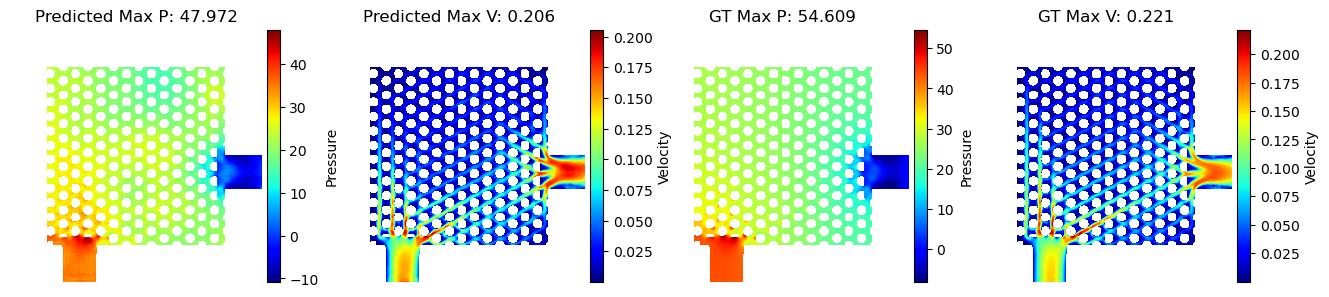

0
1000-bc_051_w_001_rn_001_inlet_top_outlet_right.npy


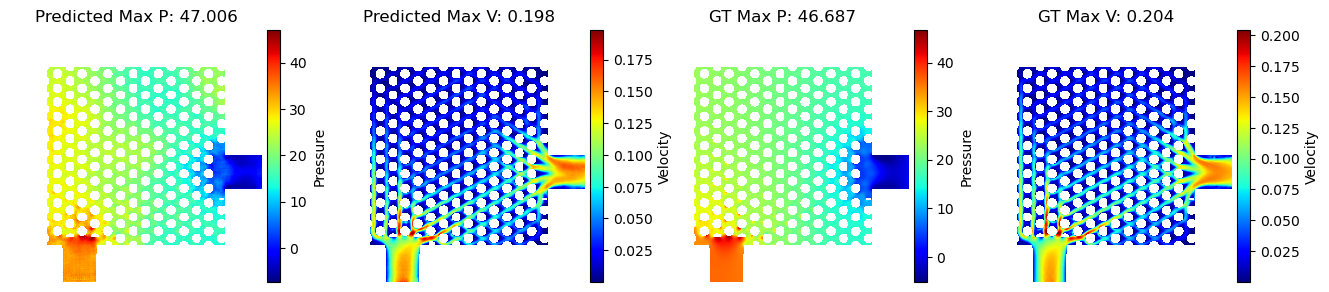

1
1000-bc_051_w_001_rn_002_inlet_top_outlet_right.npy


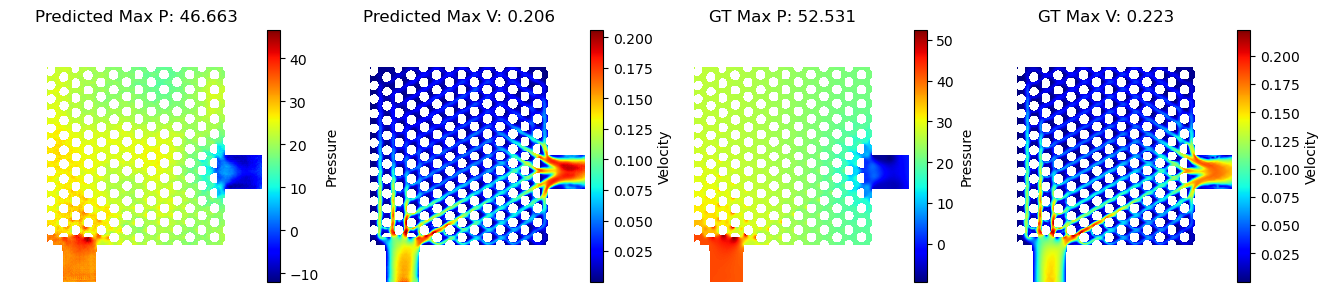

2
1000-bc_051_w_001_rn_003_inlet_top_outlet_right.npy


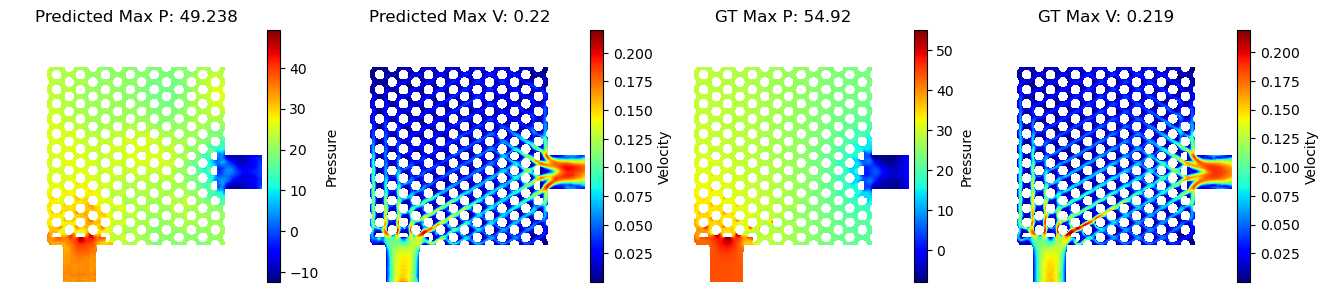

3
1000-bc_051_w_001_rn_004_inlet_top_outlet_right.npy


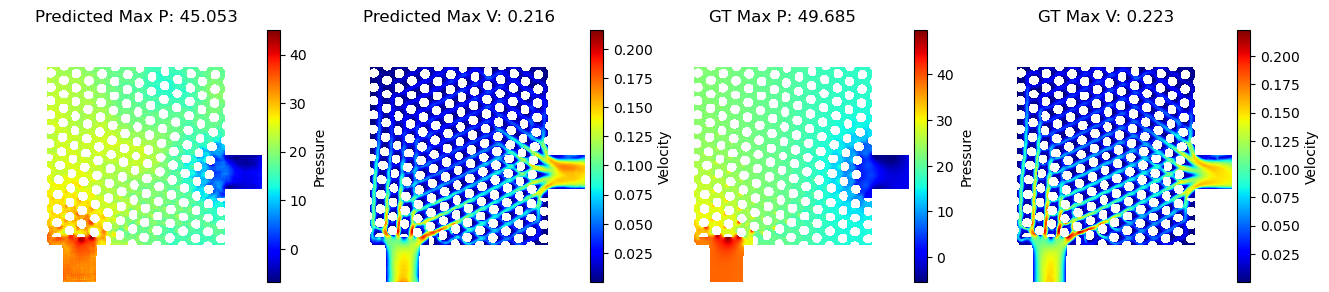

4
1000-bc_051_w_001_rn_005_inlet_top_outlet_right.npy


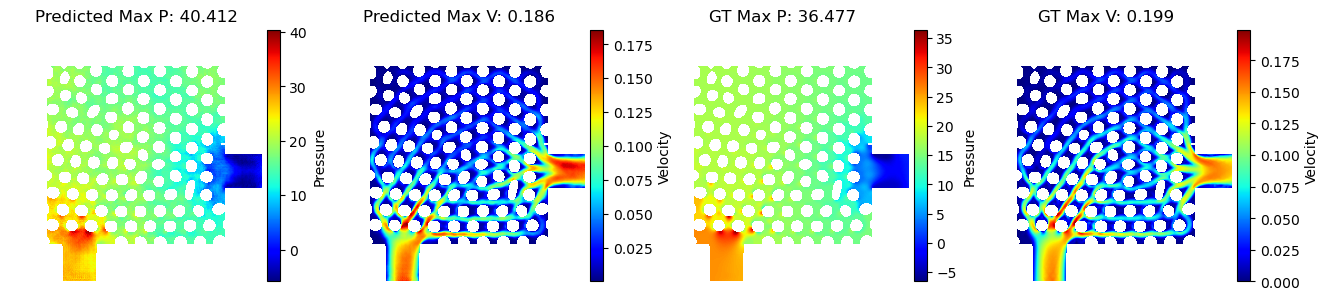

5
1000-bc_051_w_002_rn_001_inlet_top_outlet_right.npy


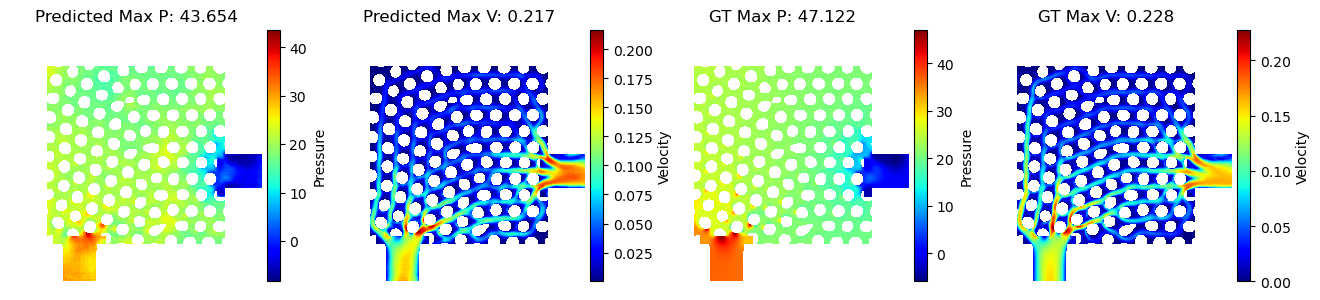

6
1000-bc_051_w_002_rn_002_inlet_top_outlet_right.npy


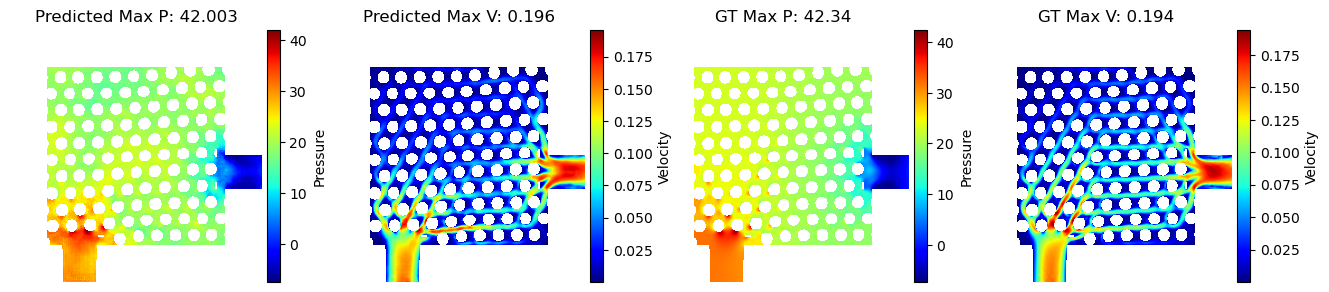

7
1000-bc_051_w_002_rn_003_inlet_top_outlet_right.npy


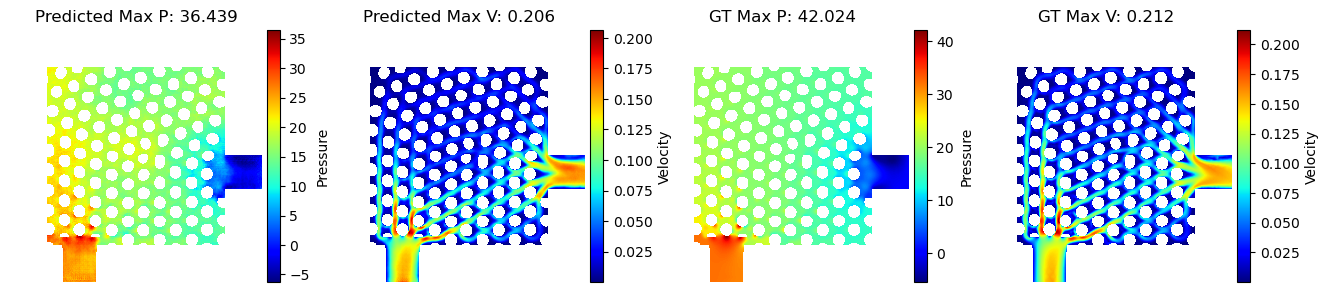

8
1000-bc_051_w_002_rn_004_inlet_top_outlet_right.npy


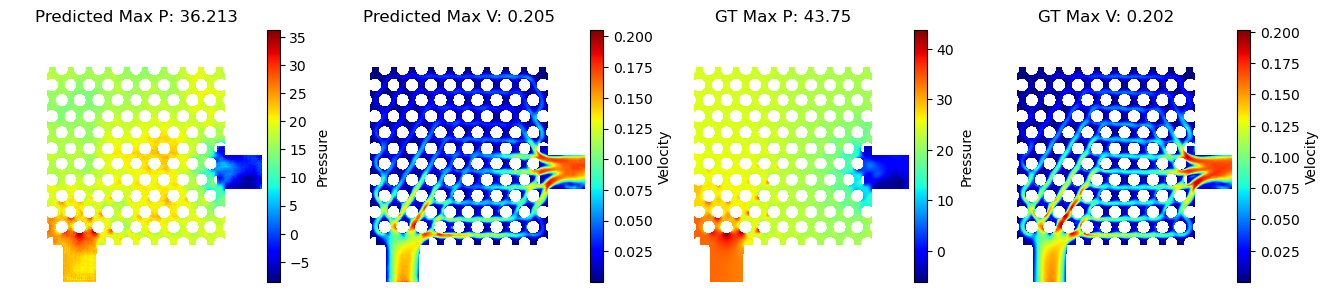

9
1000-bc_051_w_002_rn_005_inlet_top_outlet_right.npy


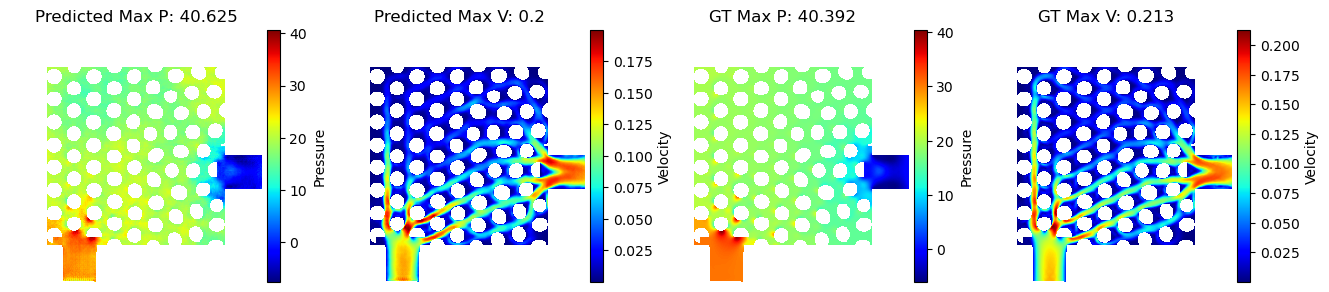

10
1000-bc_051_w_003_rn_001_inlet_top_outlet_right.npy


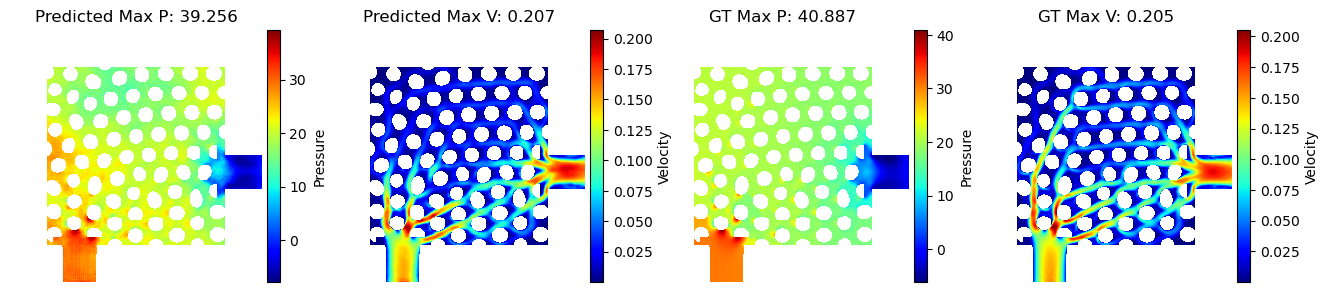

11
1000-bc_051_w_003_rn_002_inlet_top_outlet_right.npy


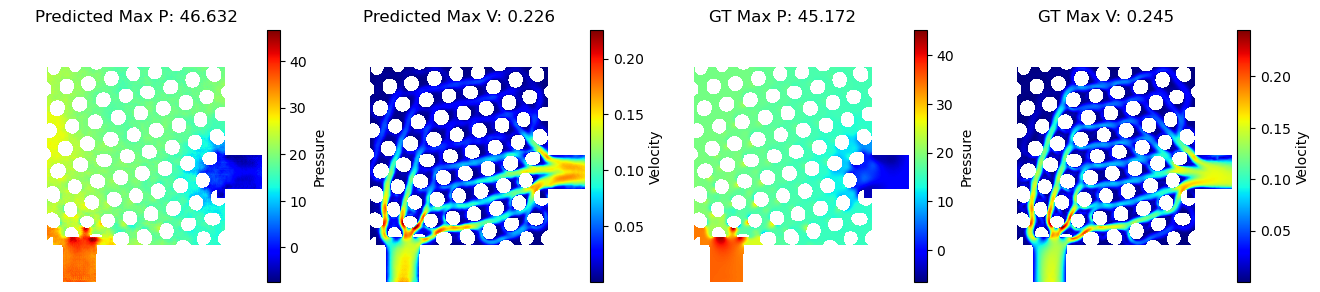

12
1000-bc_051_w_003_rn_003_inlet_top_outlet_right.npy


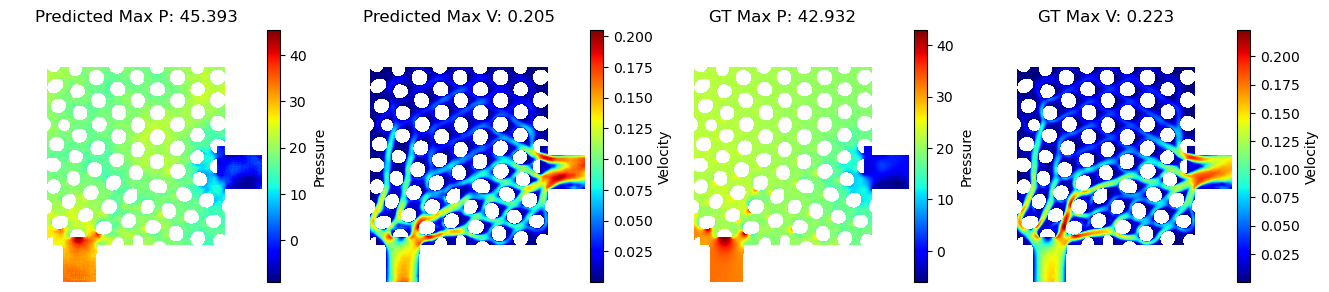

13
1000-bc_051_w_003_rn_004_inlet_top_outlet_right.npy


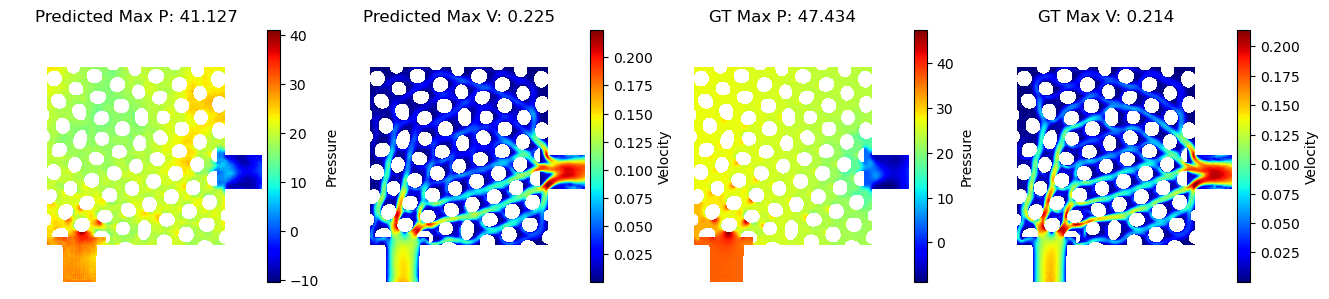

14
1000-bc_051_w_003_rn_005_inlet_top_outlet_right.npy


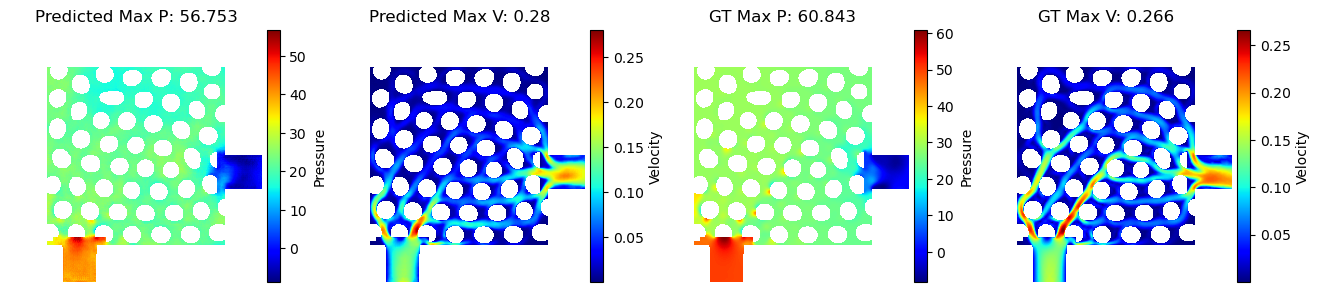

15
1000-bc_051_w_004_rn_001_inlet_top_outlet_right.npy


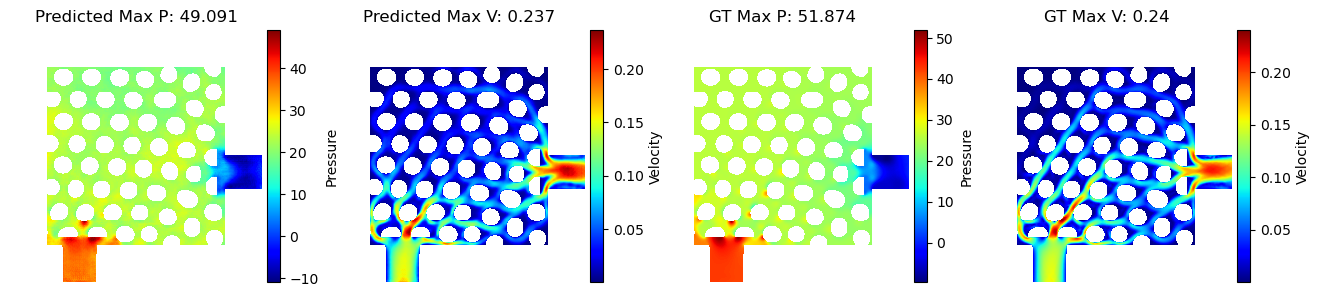

16
1000-bc_051_w_004_rn_002_inlet_top_outlet_right.npy


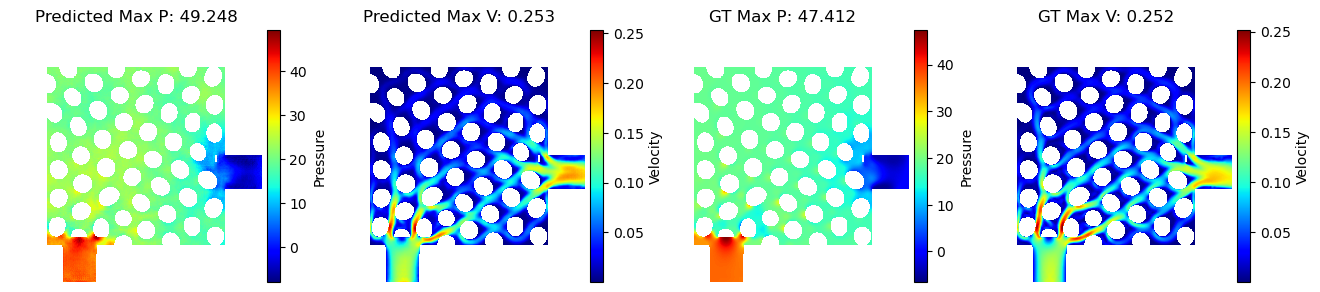

17
1000-bc_051_w_004_rn_003_inlet_top_outlet_right.npy


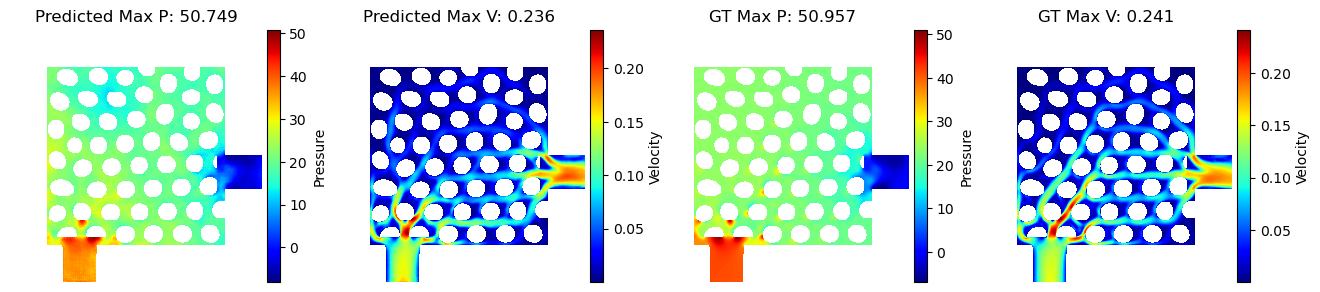

18
1000-bc_051_w_004_rn_004_inlet_top_outlet_right.npy


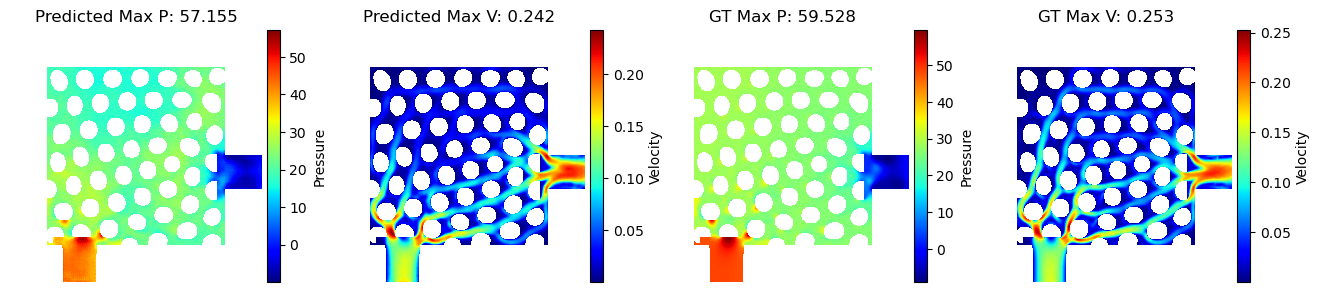

19
1000-bc_051_w_004_rn_005_inlet_top_outlet_right.npy


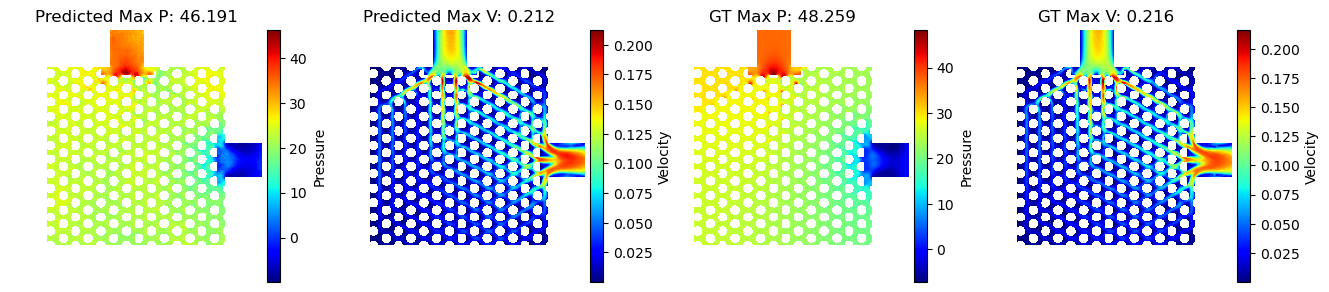

20
1000-bc_052_w_001_rn_001_inlet_bottom_outlet_right.npy


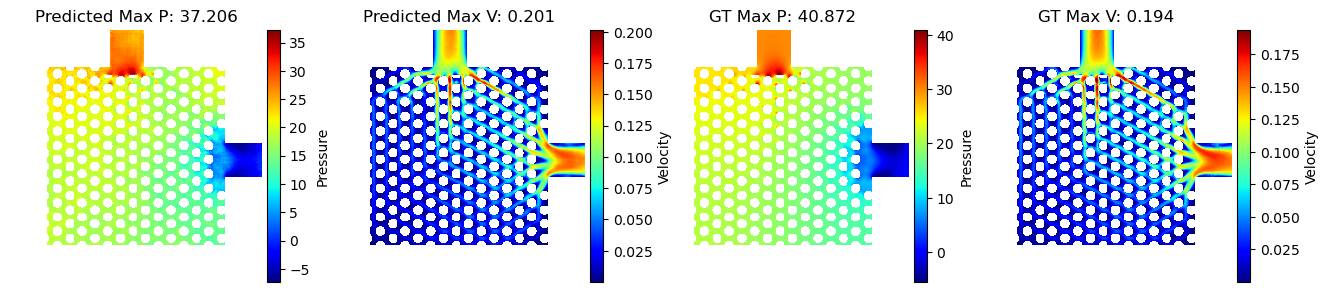

21
1000-bc_052_w_001_rn_002_inlet_bottom_outlet_right.npy


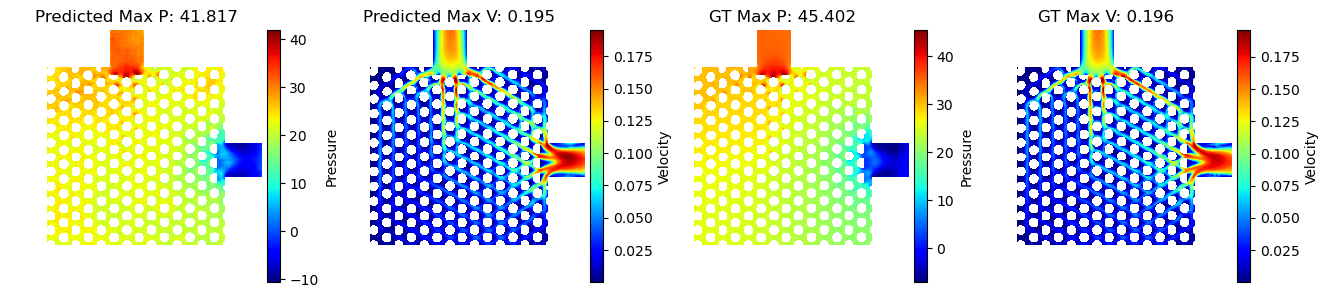

22
1000-bc_052_w_001_rn_003_inlet_bottom_outlet_right.npy


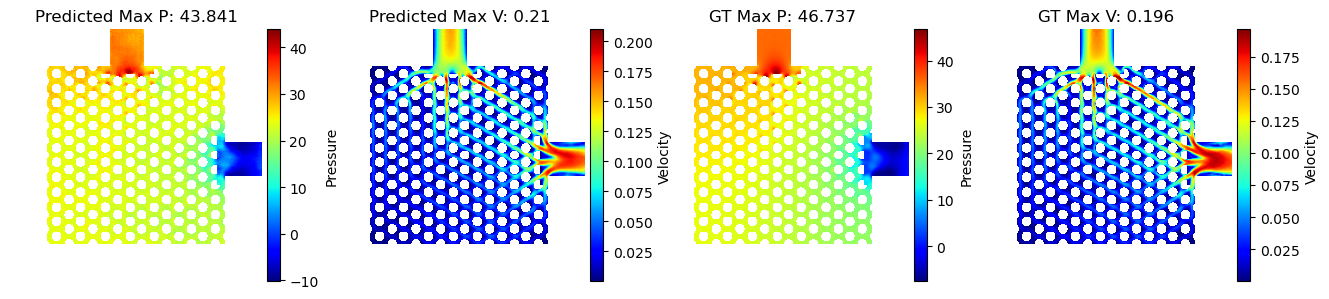

23
1000-bc_052_w_001_rn_004_inlet_bottom_outlet_right.npy


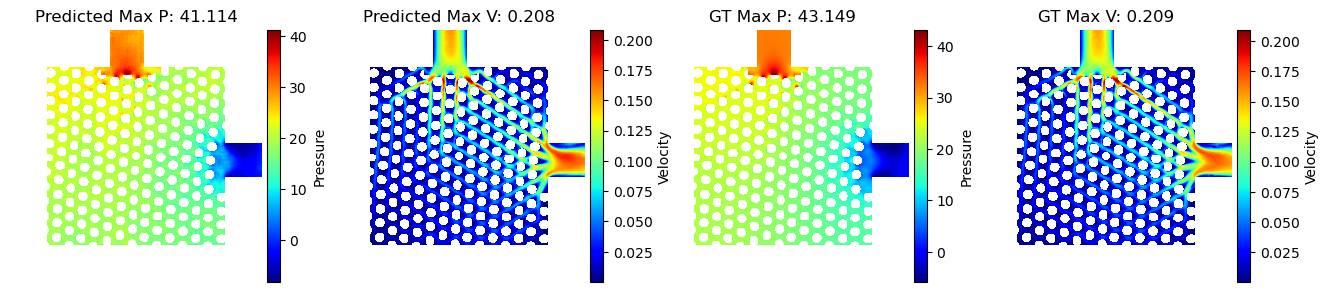

24
1000-bc_052_w_001_rn_005_inlet_bottom_outlet_right.npy


In [2]:
import matplotlib.pyplot as plt

lv2_folder = 'Validation/Low/LVV-new'
hv2_folder = 'Validation/High/HVV'
lp2_folder = 'Validation/Low/LPP-new'
hp2_folder = 'Validation/High/HPP'
lg2_folder = 'Validation/LG-3C'

# Get the list of file names in each folder
lv2_files = [f2 for f2 in os.listdir(lv2_folder) if f2 != ".ipynb_checkpoints"]
hv2_files = [f2 for f2 in os.listdir(hv2_folder) if f2 != ".ipynb_checkpoints"]
lp2_files = [f2 for f2 in os.listdir(lp2_folder) if f2 != ".ipynb_checkpoints"]
hp2_files = [f2 for f2 in os.listdir(hp2_folder) if f2 != ".ipynb_checkpoints"]
lg2_files = [f2 for f2 in os.listdir(lg2_folder) if f2 != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
lv2_files.sort()
hv2_files.sort()
lp2_files.sort()
hp2_files.sort()
lg2_files.sort()



# Create empty lists to store the data
X_lv2 = []
X_lp2 = []
X_lg2 = []
Y_hv2 = []
Y_hp2 = []

# Read the data from the folders
for lv2_file, hv2_file,lp2_file,hp2_file,lg2_file in zip(lv2_files, hv2_files,lp2_files,hp2_files,lg2_files):
    try:
        
        # Read the LFV
        lv2_image = np.load(os.path.join(lv2_folder, lv2_file))  # Convert to RGB
        X_lv2.append(np.array(lv2_image))
        
        # Read the HFV
        hv2_image = np.load(os.path.join(hv2_folder, hv2_file))  # Convert to RGB
        Y_hv2.append(np.array(hv2_image))

        # Read the LFP
        lp2_image = np.load(os.path.join(lp2_folder, lp2_file))  # Convert to RGB
        X_lp2.append(np.array(lp2_image))
    
    
        # Read the channel geometry image
        lg2_image = Image.open(os.path.join(lg2_folder, lg2_file)).convert('RGB')  # Convert to RGB
        lg2_image = lg2_image.resize(input_shape[:2])  # Resize the image
        X_lg2.append(np.array(lg2_image))
    
        # Read the HFP
        hp2_image = np.load(os.path.join(hp2_folder, hp2_file))  # Convert to RGB
        Y_hp2.append(np.array(hp2_image))
    except:
        print('')

# Convert the lists to arrays
X_lv2 = np.array(X_lv2) 
X_lp2 = np.array(X_lp2) 
X_lg2 = np.array(X_lg2) / 255.0  # Normalize the channel geometry images
Y_hv2 = np.array(Y_hv2)
Y_hp2 = np.array(Y_hp2)





X_lp2 = np.nan_to_num(X_lp2, nan=0)
X_lv2 = np.nan_to_num(X_lv2, nan=0)
X_lp2=(X_lp2-np.min(X_lp2))/(np.max(X_lp2)-np.min(X_lp2))
# Predict velocity and pressure outputs
model.load_weights('Saved_Models_Temp/data-Unet-3-Inputs.h5')
pressure_output2,velocity_output2 = model.predict([X_lg2,X_lv2,X_lp2])

velocity_output2=(velocity_output2)
a=(np.max(Y_hp)-np.min(Y_hp))
b=(np.min(Y_hp))

pressure_output2=(pressure_output2*a)+b



mask = np.all(X_lg2 > 0.8, axis=-1)

# Expand mask to match the shape of array2
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Y_hp2[mask]=np.nan
Y_hv2[mask]=np.nan
velocity_output2[mask]=np.nan
pressure_output2[mask]=np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming pressure_output, velocity_output, Y_hp, and Y_hv are defined and loaded elsewhere




def plot_images(index):
    plt.figure(figsize=(16, 48))

    # Display the pressure output
    ax1 = plt.subplot(1, 4, 1)
    im1 = ax1.imshow(pressure_output2[index],cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1, label='Pressure')
    ax1.set_title('Predicted Max P: '+ str(np.round(np.nanmax(pressure_output2[index]),decimals=3)))
    ax1.axis("off")

    # Display the velocity output
    ax2 = plt.subplot(1, 4, 2)
    im2 = ax2.imshow(velocity_output2[index],cmap='jet')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2, label='Velocity')
    ax2.set_title('Predicted Max V: '+ str(np.round(np.nanmax(velocity_output2[index]),decimals=3)))
    ax2.axis("off")

    # Display the input image (Pressure GT)
    ax3 = plt.subplot(1, 4, 3)
    im3 = ax3.imshow(Y_hp2[index],cmap='jet')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3, label='Pressure')
    ax3.set_title('GT Max P: '+ str(np.round(np.nanmax(Y_hp2[index]),decimals=3)))
    ax3.axis("off")

    # Display the velocity GT
    ax4 = plt.subplot(1, 4, 4)
    im4 = ax4.imshow(Y_hv2[index],cmap='jet')
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4, label='Velocity')
    ax4.set_title('GT Max V: '+ str(np.round(np.nanmax(Y_hv2[index]),decimals=3)))
    ax4.axis("off")

    plt.show()

# Loop to plot images 
for i in range(0, 25):
    plot_images(i)
    print(i)
    print(lv2_files[i])

In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

Yp = np.expand_dims(Y_hp2, axis=-1)
Yv = np.expand_dims(Y_hv2, axis=-1)

# Dummy data (replace with actual predicted and expected arrays)
expected = Yp
predicted = pressure_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 134.6753
MAE: 5.0388
RMSE: 11.6050
R^2: 0.7602
NRMSE: 0.0202
Relative Error: 1.3346
SMAPE: 25.2386%
Pearson Correlation: 0.8821
PSNR: 33.0161 dB


In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv
predicted = velocity_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 0.00033874
MAE: 0.0097
RMSE: 0.0184
R^2: 0.8877
NRMSE: 0.0202
Relative Error: 262117764.9482
SMAPE: 41.5709%
Pearson Correlation: 0.9427
PSNR: 33.9022 dB


In [8]:
path1="Results_Temp/Data/Unet"
os.makedirs(path1, exist_ok=True)
np.save(path1+"/velocity_predicted.npy",velocity_output2)
np.save(path1+"/pressure_predicted.npy",pressure_output2)
